Step 1 — Install & Import Libraries

In [ ]:
import subprocess, sys, re, os, math, warnings, random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")
random.seed(42)

print(" All libraries loaded successfully")
print(f"   pandas {pd.__version__} | numpy {np.__version__} | sklearn ready")

 All libraries loaded successfully
   pandas 2.2.2 | numpy 2.0.2 | sklearn ready


Step 2 — Upload Kaggle Datasets


In [ ]:
RESUME_PATH  = None
JD_PATH      = None
MONSTER_PATH = None

try:
    from google.colab import files as colab_files
    print("Running in Google Colab ✅")
    print("Upload your 3 CSV files now (or press Cancel to use synthetic data)\n")
    uploaded = colab_files.upload()
    for fname, content in uploaded.items():
        lower = fname.lower()
        path  = f"/content/{fname}"
        with open(path, "wb") as f:
            f.write(content)
        if "resume" in lower and "job" not in lower:
            RESUME_PATH = path;  print(f"✅ Resume dataset:      {fname}")
        elif "job" in lower or "description" in lower:
            JD_PATH = path;      print(f"✅ Job descriptions:    {fname}")
        elif "monster" in lower:
            MONSTER_PATH = path; print(f"✅ Monster.com dataset: {fname}")
    if not uploaded:
        print("⚠️  No files uploaded — synthetic data will be used")
except ImportError:
    print("Not running in Colab — synthetic data will be used")
except Exception as e:
    print(f"Upload skipped ({e}) — synthetic data will be used")

Running in Google Colab ✅
Upload your 3 CSV files now (or press Cancel to use synthetic data)



Saving archive (1).zip to archive (1).zip
Saving archive (2).zip to archive (2).zip
Saving archive.zip to archive.zip


Step 3 — Skill Taxonomy (148 skills, 9 categories)

In [ ]:
SKILL_TAXONOMY = {
    "programming_languages": [
        "python","java","javascript","typescript","c++","c#","r","scala","go",
        "rust","kotlin","swift","php","ruby","matlab","sql","bash","shell","perl","julia",
    ],
    "ml_ai": [
        "machine learning","deep learning","neural network","nlp",
        "natural language processing","computer vision","reinforcement learning",
        "transfer learning","generative ai","llm","transformers","bert","gpt",
        "xgboost","lightgbm","catboost","random forest","gradient boosting",
        "decision tree","svm","support vector machine","clustering","classification",
        "regression","time series","anomaly detection","recommender system","feature engineering",
    ],
    "ml_frameworks": [
        "tensorflow","pytorch","keras","scikit-learn","sklearn","hugging face",
        "fastai","opencv","nltk","spacy","gensim","mlflow","kubeflow","ray","sagemaker",
    ],
    "data_tools": [
        "pandas","numpy","matplotlib","seaborn","plotly","tableau","power bi","looker",
        "excel","spark","hadoop","kafka","airflow","dbt","databricks","jupyter","dask",
    ],
    "databases": [
        "mysql","postgresql","mongodb","redis","cassandra","elasticsearch","sqlite",
        "oracle","dynamodb","firebase","bigquery","snowflake","redshift",
    ],
    "cloud_devops": [
        "aws","azure","gcp","google cloud","docker","kubernetes","terraform","ansible",
        "helm","jenkins","gitlab","github actions","ci/cd","git","github",
        "prometheus","grafana","linux","unix",
    ],
    "web_frameworks": [
        "django","flask","fastapi","react","angular","vue","node.js","express",
        "spring","graphql","rest api","microservices","html","css",
    ],
    "soft_skills": [
        "communication","leadership","teamwork","problem solving","critical thinking",
        "project management","agile","scrum","collaboration","analytical",
        "attention to detail","time management",
    ],
    "statistics": [
        "statistics","probability","hypothesis testing","a/b testing","bayesian",
        "linear algebra","calculus","data visualization","model evaluation","cross validation",
    ],
}

ALL_SKILLS = {skill: cat for cat, skills in SKILL_TAXONOMY.items() for skill in skills}

print(f" {len(ALL_SKILLS)} skills across {len(SKILL_TAXONOMY)} categories loaded")
pd.DataFrame([
    {"Category": cat, "Count": len(skills), "Sample Skills": ", ".join(skills[:6])}
    for cat, skills in SKILL_TAXONOMY.items()
])

 148 skills across 9 categories loaded


,Category,Count,Sample Skills
0,programming_languages,20,"python, java, javascript, typescript, c++, c#"
1,ml_ai,28,"machine learning, deep learning, neural networ..."
2,ml_frameworks,15,"tensorflow, pytorch, keras, scikit-learn, skle..."
3,data_tools,17,"pandas, numpy, matplotlib, seaborn, plotly, ta..."
4,databases,13,"mysql, postgresql, mongodb, redis, cassandra, ..."
5,cloud_devops,19,"aws, azure, gcp, google cloud, docker, kubernetes"
6,web_frameworks,14,"django, flask, fastapi, react, angular, vue"
7,soft_skills,12,"communication, leadership, teamwork, problem s..."
8,statistics,10,"statistics, probability, hypothesis testing, a..."


Step 4 — Text Preprocessing Utilities

In [ ]:
STOPWORDS = {
    "the","a","an","and","or","but","in","on","at","to","for","of","with","by",
    "from","is","was","are","were","be","been","have","has","had","do","did",
    "will","would","could","should","may","might","not","that","this","these",
    "those","i","we","you","he","she","they","it","my","our","your","his","her",
    "their","its","as","if","so","than","then","when","where","which","who","how",
    "what","years","year","experience","work","working","worked","using","used",
    "including","also","such","through","about","into","over","during","up","out",
    "team","company","role","seeking","looking","join","opportunity","must",
    "required","requirements","responsibilities",
}

def clean_text(text):
    """Lowercase, strip URLs and special chars, collapse whitespace."""
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[^\w\s\+\#\.\-\/]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

def extract_skills(text):
    """Return {skill: category} for every taxonomy skill found in text."""
    tl = text.lower()
    found = {}
    for skill in sorted(ALL_SKILLS, key=lambda x: -len(x)):   # longest-first
        if re.search(r"\b" + re.escape(skill) + r"\b", tl):
            found[skill] = ALL_SKILLS[skill]
    return found

def extract_years_experience(text):
    """Heuristically pull years-of-experience from resume text."""
    for pat in [r"(\d+)\+?\s*years?\s+of\s+experience",
                r"(\d+)\+?\s*years?\s+experience",
                r"experience\s*[:–\-]\s*(\d+)",
                r"(\d+)\s*\-\s*\d+\s*years"]:
        m = re.search(pat, text.lower())
        if m: return min(int(m.group(1)), 20)
    count = len(re.findall(r"\b(senior|lead|principal|staff|junior|associate)\b", text.lower()))
    return min(count * 2, 12)

def extract_education_score(text):
    """Map detected degree level to a 0–1 float."""
    t = text.lower()
    if re.search(r"\bph\.?d\b|\bdoctor", t):                    return 1.00
    if re.search(r"\bm\.?s\.?\b|\bm\.?tech\b|\bmaster", t): return 0.85
    if re.search(r"\bmba\b", t):                                   return 0.82
    if re.search(r"\bb\.?s\.?\b|\bb\.?e\.?\b|\bbachelor", t): return 0.70
    if re.search(r"\bassociate\b|\bdiploma\b", t):               return 0.55
    return 0.50

# Quick smoke test
sample = "Built deep learning models with PyTorch and TensorFlow on AWS using Pandas and NumPy"
skills_found = extract_skills(sample)
print(f" Preprocessing utilities ready")
print(f"   Smoke test — skills extracted from sample text: {list(skills_found.keys())}")

 Preprocessing utilities ready
   Smoke test — skills extracted from sample text: ['deep learning', 'tensorflow', 'pytorch', 'pandas', 'numpy', 'aws']


Step 5 — Synthetic Dataset Generator

In [ ]:
COMPANIES = ["Google","Meta","Amazon","Microsoft","Apple","Netflix","Uber","Airbnb",
             "Stripe","Salesforce","IBM","Oracle","Adobe","Spotify","Nvidia","Intel",
             "Palantir","Snowflake","Databricks","OpenAI"]
LOCATIONS  = ["San Francisco, CA","New York, NY","Seattle, WA","Austin, TX",
              "Boston, MA","Chicago, IL","Los Angeles, CA","Remote"]
NAMES      = [("Alice Johnson","alice.j@email.com"),("Bob Martinez","bob.m@email.com"),
              ("Carol White","carol.w@email.com"),  ("David Kim","david.k@email.com"),
              ("Emma Wilson","emma.w@email.com"),   ("Frank Chen","frank.c@email.com"),
              ("Grace Patel","grace.p@email.com"),  ("Henry Brown","henry.b@email.com"),
              ("Iris Davis","iris.d@email.com"),    ("James Garcia","james.g@email.com"),
              ("Karen Lee","karen.l@email.com"),    ("Liam Taylor","liam.t@email.com"),
              ("Maya Singh","maya.s@email.com"),    ("Noah Anderson","noah.a@email.com"),
              ("Olivia Thomas","olivia.t@email.com"),("Peter Jackson","peter.j@email.com"),
              ("Quinn Harris","quinn.h@email.com"), ("Rachel Lopez","rachel.l@email.com"),
              ("Sam Walker","sam.w@email.com"),     ("Tina Hall","tina.h@email.com")]
EDUS = ["B.S.","B.E.","M.S.","M.Tech.","Ph.D.","MBA"]

RESUME_TEMPLATES = {
"Data Science": """{name} | {email}
SUMMARY: Data Scientist with {exp} years experience in machine learning, Python,
NLP, and statistical modeling. Proven track record deploying predictive models.
EXPERIENCE: Senior Data Scientist — {company} ({exp} years)
• Machine learning: TensorFlow, PyTorch, Scikit-learn, XGBoost, gradient boosting
• NLP pipelines: BERT, Hugging Face transformers, spaCy, NLTK, deep learning
• Neural networks: classification, clustering, regression, time series, A/B testing
• Data tools: Pandas, NumPy, Matplotlib, Seaborn, Tableau, Power BI, Jupyter
• Cloud & MLOps: AWS, Docker, Kubernetes, MLflow, Airflow, Spark, Kafka
• Databases: PostgreSQL, MongoDB; Statistics, Hypothesis testing, Probability
SKILLS: Python, R, SQL, TensorFlow, PyTorch, Scikit-learn, Keras, XGBoost,
Pandas, NumPy, Matplotlib, Seaborn, Tableau, Power BI, Spark, AWS, Docker,
Kubernetes, Git, MLflow, NLTK, spaCy, Machine Learning, Deep Learning, NLP,
Regression, Classification, Clustering, A/B Testing, Hypothesis Testing,
PostgreSQL, MongoDB, Airflow, Statistics, Probability, Linux
EDUCATION: {edu} Computer Science / Data Science""",

"Machine Learning": """{name} | {email}
ML ENGINEER — {exp} YEARS
EXPERIENCE: ML Engineer — {company}
• Production ML: PyTorch, TensorFlow, Keras, XGBoost, LightGBM, Scikit-learn
• MLOps: MLflow, Kubeflow, Airflow, Ray; deep learning: CNNs, RNNs, Transformers
• NLP, computer vision, reinforcement learning; Hugging Face, BERT, GPT
• Distributed training: Spark, Kafka on AWS, GCP, Azure; Docker, Kubernetes
• CI/CD: Jenkins, GitLab; Linux system administration
SKILLS: Python, Scala, SQL, Bash, TensorFlow, PyTorch, Scikit-learn, XGBoost,
Hugging Face, MLflow, Kubeflow, Airflow, Ray, AWS, GCP, Azure, Docker,
Kubernetes, Terraform, Spark, Kafka, Redis, PostgreSQL, MongoDB,
Machine Learning, Deep Learning, NLP, Computer Vision, Git, Linux, CI/CD, Agile
EDUCATION: {edu} Computer Science / Electrical Engineering""",

"Web Designing": """{name} | {email}
Full Stack Developer — {exp} years
EXPERIENCE: Senior Developer — {company}
• Frontend: React, Angular, Vue.js, TypeScript, JavaScript, HTML5, CSS3, SASS
• Backend: Node.js, Django, Flask, FastAPI, Spring Boot; REST API, GraphQL
• Databases: MySQL, PostgreSQL, MongoDB, Redis, Firebase
• Cloud & DevOps: AWS, Docker, Kubernetes, Jenkins, CI/CD, Git
• Microservices architecture; Agile/Scrum
SKILLS: React, Angular, Vue, JavaScript, TypeScript, HTML, CSS, SASS,
Node.js, Django, Flask, FastAPI, Spring Boot, MySQL, PostgreSQL, MongoDB,
Redis, Firebase, AWS, Docker, Kubernetes, Jenkins, CI/CD, Git,
GraphQL, REST API, Microservices, Agile, Scrum, Linux
EDUCATION: {edu} Computer Science / Software Engineering""",

"Java Developer": """{name} | {email}
Java Software Engineer — {exp} years
EXPERIENCE: Senior Java Developer — {company}
• Enterprise apps: Java, Spring Boot, Hibernate, Maven; REST API, microservices
• Databases: MySQL, PostgreSQL, Oracle, MongoDB, Redis; Kafka, RabbitMQ
• AWS: EC2, S3, RDS, Lambda; Docker, Kubernetes; Jenkins CI/CD
• Testing: JUnit, Mockito; Git version control; Agile/Scrum
SKILLS: Java, Python, SQL, Spring Boot, Spring Cloud, Hibernate, MySQL,
PostgreSQL, Oracle, MongoDB, Redis, AWS, Docker, Kubernetes, Jenkins,
CI/CD, Git, Kafka, RabbitMQ, REST API, Microservices, JUnit, Mockito, Agile
EDUCATION: {edu} Computer Science""",

"Python Developer": """{name} | {email}
Python Software Developer — {exp} years
EXPERIENCE: Python Developer — {company}
• Backend services: Django, Flask, FastAPI; data pipelines: Pandas, NumPy, PySpark
• Async queues: Celery, Redis; databases: PostgreSQL, MySQL, MongoDB, Elasticsearch
• Docker, Kubernetes on AWS and GCP; REST APIs, GraphQL endpoints
• Clean Python: pytest, PEP8, type hints; Git, CI/CD
SKILLS: Python, SQL, JavaScript, Bash, Django, Flask, FastAPI, Celery,
SQLAlchemy, Pandas, NumPy, Matplotlib, Scikit-learn, PostgreSQL, MySQL,
MongoDB, Redis, Elasticsearch, AWS, GCP, Docker, Kubernetes, Jenkins,
CI/CD, Git, Agile, Pytest, Linux
EDUCATION: {edu} Computer Science / Software Engineering""",

"DevOps Engineer": """{name} | {email}
DevOps / Cloud Engineer — {exp} years
EXPERIENCE: Senior DevOps Engineer — {company}
• Cloud IaC: AWS, GCP, Azure; Terraform, Ansible, CloudFormation
• Kubernetes clusters, Helm charts, Docker containerization
• CI/CD: Jenkins, GitLab, GitHub Actions, ArgoCD
• Monitoring: Prometheus, Grafana, ELK Stack, Datadog
• Bash, Python, Go automation; IAM, VPC, Vault secrets; Linux admin
SKILLS: AWS, GCP, Azure, Terraform, Ansible, CloudFormation, Helm, Jenkins,
GitLab, GitHub Actions, ArgoCD, Docker, Kubernetes, Prometheus, Grafana,
ELK, Datadog, Bash, Python, Go, SQL, PostgreSQL, MySQL, MongoDB, Redis,
IAM, Linux, Unix, Git, CI/CD
EDUCATION: {edu} Computer Science / Information Systems""",

"HR": """{name} | {email}
Human Resources Manager — {exp} years
EXPERIENCE: HR Manager — {company}
• Full-cycle recruitment, employee relations, performance management
• HRIS: Workday, SAP SuccessFactors, BambooHR, ADP
• Training programs, diversity & inclusion, compliance, labor law
• Compensation & benefits, payroll coordination, conflict resolution
• Excel, PowerPoint, Tableau for HR analytics
SKILLS: Recruitment, Talent Acquisition, Employee Relations,
Performance Management, Workday, SAP SuccessFactors, BambooHR,
Training Development, Compensation Benefits, Compliance, Labor Law,
Diversity Inclusion, Excel, PowerPoint, Tableau,
Communication, Leadership, Negotiation, Problem Solving
EDUCATION: {edu} Human Resources / Business Administration""",

"Accountant": """{name} | {email}
Certified Accountant (CPA) — {exp} years
EXPERIENCE: Senior Accountant — {company}
• Financial statements: P&L, Balance Sheet, Cash Flow — GAAP/IFRS
• AR/AP, general ledger, internal/external audits; tax compliance
• Accounting software: QuickBooks, SAP, Oracle Financials, NetSuite
• Financial modeling, budgeting, variance analysis: Excel, Power BI, Tableau
• Month-end/year-end close; federal and state tax returns
SKILLS: Financial Reporting, GAAP, IFRS, Tax Compliance, Auditing,
Accounts Payable, Accounts Receivable, General Ledger, Payroll,
QuickBooks, SAP, Oracle Financials, NetSuite, Excel, Power BI, Tableau,
Budgeting, Forecasting, Financial Modeling, CPA, Communication
EDUCATION: {edu} Accounting / Finance""",

"Business Analyst": """{name} | {email}
Business Analyst — {exp} years
EXPERIENCE: Senior Business Analyst — {company}
• Requirements gathering via stakeholder interviews; user stories, BRDs
• Dashboards: Tableau, Power BI, Excel; SQL for ad-hoc analysis
• Gap analysis, process mapping, workflow optimization
• Agile ceremonies: sprint planning, retrospectives, stand-ups
• JIRA, Confluence, MS Visio documentation; financial models, ROI analysis
SKILLS: Business Requirements, Gap Analysis, Process Mapping, SQL, Excel,
Tableau, Power BI, Python, R, JIRA, Confluence, MS Visio, Agile, Scrum,
Waterfall, SDLC, Stakeholder Management, Communication,
Financial Modeling, Data Analysis, Problem Solving
EDUCATION: {edu} Business Administration / Information Systems""",

"Network Security Engineer": """{name} | {email}
Network Security Engineer — {exp} years
EXPERIENCE: Senior Security Engineer — {company}
• Network security: Palo Alto, Cisco, Fortinet firewalls; IDS/IPS systems
• Penetration testing, vulnerability assessments, SIEM: Splunk, QRadar
• Endpoint security, DLP, IAM; incident response, digital forensics
• NIST, ISO 27001, SOC 2, PCI-DSS compliance; AWS and Azure security
• Python and Bash scripting for security automation
SKILLS: Network Security, Firewalls, IDS/IPS, Penetration Testing,
Vulnerability Assessment, Splunk, QRadar, SIEM, AWS Security, Azure Security,
Python, Bash, SQL, PowerShell, NIST, ISO 27001, SOC 2, PCI-DSS,
Incident Response, Digital Forensics, TCP/IP, VPN, SSL/TLS, DNS, Linux
EDUCATION: {edu} Computer Science / Cybersecurity""",
}

JD_TEMPLATES = {
"Data Scientist": {
  "skills": "Python, R, Machine Learning, Deep Learning, TensorFlow, PyTorch, Scikit-learn, SQL, Spark, NLP, Statistics, A/B Testing, AWS, Docker, Kubernetes, MLflow, BERT, Pandas, NumPy, Tableau, Airflow, PostgreSQL, MongoDB, Probability, Hypothesis Testing, Communication, Agile",
  "description": """We are seeking a talented Data Scientist to join our AI team.
Requirements: 3+ years Data Science / Machine Learning. Strong Python and SQL.
TensorFlow, PyTorch, Scikit-learn, XGBoost, LightGBM.
NLP: BERT, Hugging Face, spaCy, NLTK, deep learning, neural networks.
Statistical modeling: regression, classification, clustering, time series, A/B testing.
Bayesian inference, hypothesis testing, probability.
Cloud: AWS, GCP, Azure. Docker, Kubernetes, MLflow, Airflow.
Data: Pandas, NumPy, Matplotlib, Seaborn, Tableau, Power BI, Spark, Kafka.
Databases: PostgreSQL, MongoDB. Communication, agile, scrum, teamwork, leadership."""
},
"Machine Learning Engineer": {
  "skills": "Python, TensorFlow, PyTorch, Scikit-learn, MLOps, Kubernetes, Docker, Spark, AWS, GCP, Airflow, MLflow, CI/CD, SQL, Kubeflow, Kafka, Linux, NLP, Computer Vision",
  "description": """Senior ML Engineer to build production ML systems at scale.
Requirements: 4+ years ML engineering. Expert Python.
Deep learning: TensorFlow, PyTorch, Keras. MLOps: MLflow, Kubeflow, Airflow, Ray.
Cloud: AWS, GCP, Azure, Terraform. Distributed: Spark, Kafka.
Docker, Kubernetes, Helm, CI/CD Jenkins/GitLab. Linux system administration.
NLP, computer vision, reinforcement learning. Communication, agile, teamwork."""
},
"Full Stack Developer": {
  "skills": "React, Node.js, Python, TypeScript, AWS, Docker, PostgreSQL, MongoDB, REST API, GraphQL, CI/CD, Kubernetes, Git, Agile, JavaScript, HTML, CSS, Django, Flask",
  "description": """Full Stack Developer to build scalable web applications.
Requirements: 3+ years full-stack. React, Angular, Vue; JavaScript, TypeScript, HTML, CSS.
Backend: Node.js, Django, Flask, FastAPI. Databases: PostgreSQL, MySQL, MongoDB, Redis.
Cloud: AWS, Docker, Kubernetes, CI/CD. REST API and GraphQL. Git, Agile, Scrum.
Communication, problem solving, teamwork."""
},
"DevOps Engineer": {
  "skills": "AWS, GCP, Azure, Kubernetes, Docker, Terraform, Jenkins, CI/CD, Ansible, Python, Bash, Prometheus, Grafana, Linux, Git, Helm, Monitoring",
  "description": """DevOps / Cloud Engineer to automate and scale infrastructure.
Requirements: 3+ years DevOps. AWS, GCP, Azure. Kubernetes, Helm, Docker.
Terraform, Ansible, CloudFormation. CI/CD: Jenkins, GitLab, ArgoCD.
Prometheus, Grafana, ELK, Datadog. Python, Bash scripting. Linux admin.
Communication, problem solving, agile, teamwork."""
},
"Data Analyst": {
  "skills": "SQL, Python, R, Tableau, Power BI, Excel, Statistics, A/B Testing, Pandas, NumPy, Matplotlib, PostgreSQL, ETL, Communication",
  "description": """Data Analyst to drive insights and support decisions.
Requirements: 2+ years data analysis. Strong SQL (PostgreSQL, MySQL) and Python.
Pandas, NumPy, Matplotlib, Seaborn. BI: Tableau, Power BI, Looker.
Statistics: regression, hypothesis testing, A/B testing. Excel advanced.
ETL pipeline development. Communication, data storytelling, agile."""
},
"Software Engineer": {
  "skills": "Python, Java, C++, Algorithms, Data Structures, AWS, Docker, Git, REST API, SQL, PostgreSQL, Agile, CI/CD, Microservices, Linux",
  "description": """Software Engineer to build scalable backend systems.
Requirements: 2+ years software engineering. Strong CS fundamentals.
Python, Java, C++, or Go. PostgreSQL, MongoDB, Redis.
REST API, microservices, distributed systems. AWS, Docker, Kubernetes.
Git, CI/CD, Agile. Communication, teamwork, problem solving."""
},
}

def generate_synthetic_data(n_per_category=25, n_jd_per_role=15, n_monster=150):
    rows_r, uid = [], 1000
    for cat, tmpl in RESUME_TEMPLATES.items():
        for i in range(n_per_category):
            name, email = NAMES[i % len(NAMES)]
            text = tmpl.format(name=name, email=email, exp=random.randint(1,10),
                               company=random.choice(COMPANIES), edu=random.choice(EDUS)).strip()
            rows_r.append({"ID": uid, "Resume_str": text,
                           "Resume_html": f"<div>{text[:80]}...</div>", "Category": cat})
            uid += 1
    df_r = pd.DataFrame(rows_r)

    rows_j = []
    for role, meta in JD_TEMPLATES.items():
        for _ in range(n_jd_per_role):
            rows_j.append({"Job Title": role, "Role": role,
                           "Company": random.choice(COMPANIES),
                           "location": random.choice(LOCATIONS),
                           "Job Description": meta["description"].strip(),
                           "skills": meta["skills"],
                           "Experience": f"{random.randint(1,3)}-{random.randint(4,7)} years",
                           "Work Type": random.choice(["Full-Time","Remote","Hybrid","Contract"])})
    df_j = pd.DataFrame(rows_j)

    SECTORS = {"Information Technology": ["Software Engineer","Data Scientist","ML Engineer","DevOps Engineer","Full Stack Developer"],
               "Finance": ["Financial Analyst","Data Analyst"], "Healthcare": ["Clinical Data Scientist"],
               "Marketing": ["Marketing Analyst"], "Operations": ["Business Analyst"]}
    SNIPPETS = ["Strong Python, SQL, cloud experience required.",
                "Hands-on ML and data engineering skills needed.",
                "Docker, Kubernetes, CI/CD required.",
                "Build dashboards and communicate insights.",
                "Distributed systems and backend experience valued."]
    all_pairs = [(s,t) for s,ts in SECTORS.items() for t in ts]
    rows_m = [{"job_id": 10000+i, "title": t, "company": random.choice(COMPANIES),
               "description": random.choice(SNIPPETS), "location": random.choice(LOCATIONS),
               "sector": s, "country": "US"} for i,(s,t) in enumerate(random.choices(all_pairs, k=n_monster))]
    df_m = pd.DataFrame(rows_m)
    return df_r, df_j, df_m

print(" Synthetic data generator ready")

 Synthetic data generator ready


Step 6 — Load Datasets (Kaggle CSVs or Synthetic)

In [ ]:
def load_resume_df(path):
    df = pd.read_csv(path); df.columns = [c.strip() for c in df.columns]
    if "Resume_str" not in df.columns:
        for alt in ["Resume","resume","text","resume_text"]:
            if alt in df.columns: df["Resume_str"] = df[alt]; break
    if "Category" not in df.columns:
        for alt in ["category","label","job_category"]:
            if alt in df.columns: df["Category"] = df[alt]; break
        else: df["Category"] = "Unknown"
    df = df.dropna(subset=["Resume_str"])
    df["Resume_str"] = df["Resume_str"].astype(str)
    df["Category"]   = df["Category"].fillna("Unknown").astype(str)
    return df

def load_jd_df(path):
    df = pd.read_csv(path); df.columns = [c.strip() for c in df.columns]
    for alt in ["description","Description","job_description","Job Description"]:
        if alt in df.columns and "Job Description" not in df.columns:
            df["Job Description"] = df[alt]; break
    for alt in ["Job Title","title","Title","Role","role","job_title"]:
        if alt in df.columns and "Job Title" not in df.columns:
            df["Job Title"] = df[alt]; break
    return df.dropna(subset=["Job Description"])

def load_monster_df(path):
    df = pd.read_csv(path); df.columns = [c.strip() for c in df.columns]
    for alt in ["description","job_description","body"]:
        if alt in df.columns and "description" not in df.columns:
            df["description"] = df[alt]; break
    return df.dropna(subset=["description"])

# Auto-detect
USE_SYNTHETIC = not (RESUME_PATH and JD_PATH and MONSTER_PATH)

if USE_SYNTHETIC:
    print("  Kaggle files not found — generating synthetic data (identical schemas)\n")
    df_resume, df_jd, df_monster = generate_synthetic_data(n_per_category=25, n_jd_per_role=15, n_monster=150)
else:
    print(" Loading real Kaggle datasets...\n")
    df_resume  = load_resume_df(RESUME_PATH)
    df_jd      = load_jd_df(JD_PATH)
    df_monster = load_monster_df(MONSTER_PATH)

print(f" Resume Dataset   : {len(df_resume):,} rows | {df_resume['Category'].nunique()} categories")
print(f" Job Descriptions : {len(df_jd):,} rows | {df_jd['Job Title'].nunique()} unique roles")
print(f" Monster.com Jobs : {len(df_monster):,} rows | {df_monster.get('sector', pd.Series(['?'])).nunique()} sectors")
print(f"\nResume categories:")
for cat, cnt in df_resume["Category"].value_counts().items():
    print(f"  • {cat:<32} {cnt} resumes")

  Kaggle files not found — generating synthetic data (identical schemas)

 Resume Dataset   : 250 rows | 10 categories
 Job Descriptions : 90 rows | 6 unique roles
 Monster.com Jobs : 150 rows | 5 sectors

Resume categories:
  • Data Science                     25 resumes
  • Machine Learning                 25 resumes
  • Web Designing                    25 resumes
  • Java Developer                   25 resumes
  • Python Developer                 25 resumes
  • DevOps Engineer                  25 resumes
  • HR                               25 resumes
  • Accountant                       25 resumes
  • Business Analyst                 25 resumes
  • Network Security Engineer        25 resumes


Step 7 — Core ML Screening Pipeline

In [ ]:
class ResumeScreeningPipeline:
    """
    End-to-end ML Resume Screening System.
    Weights: 35% skill match | 30% TF-IDF | 15% category coverage | 12% experience | 8% education
    """
    WEIGHTS = {"tfidf": 0.30, "skill": 0.35, "category": 0.15, "exp": 0.12, "edu": 0.08}

    def __init__(self, target_role, jd_df, resume_df):
        self.target_role = target_role
        self.resume_df   = resume_df
        self.results     = None
        self.job_description = self._build_jd(jd_df)
        self.jd_clean        = clean_text(self.job_description)
        self.jd_skills       = extract_skills(self.job_description)
        self.jd_categories   = set(self.jd_skills.values())
        self.vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=8000, sublinear_tf=True, min_df=1)
        print(f"\n   Role     : {target_role}")
        print(f"   JD Skills: {len(self.jd_skills)} across {len(self.jd_categories)} categories")
        print(f"  Resumes  : {len(resume_df)} to screen")

    def _build_jd(self, jd_df):
        col   = "Job Title" if "Job Title" in jd_df.columns else "Role"
        mask  = jd_df[col].str.lower().str.contains(self.target_role.lower(), na=False)
        matched = jd_df[mask]
        if matched.empty:
            kw = self.target_role.split()[0].lower()
            matched = jd_df[jd_df[col].str.lower().str.contains(kw, na=False)]
        if matched.empty:
            raise ValueError(f"Role '{self.target_role}' not found. Available: {sorted(jd_df[col].dropna().unique())}")
        parts = []
        for _, row in matched.head(5).iterrows():
            if "Job Description" in row and pd.notna(row["Job Description"]): parts.append(str(row["Job Description"]))
            if "skills"          in row and pd.notna(row.get("skills","")):    parts.append(str(row["skills"]))
        return " ".join(parts)

    def _score_one(self, resume_text, category):
        rc  = clean_text(resume_text)
        rsk = extract_skills(resume_text)
        tf  = self.vectorizer.fit_transform([self.jd_clean, rc])
        cos = float(cosine_similarity(tf[0:1], tf[1:2])[0][0])
        req, cand = set(self.jd_skills), set(rsk)
        matched, missing, bonus = req & cand, req - cand, cand - req
        skr  = len(matched) / max(len(req), 1)
        catc = len(self.jd_categories & set(rsk.values())) / max(len(self.jd_categories), 1)
        yrs  = extract_years_experience(resume_text)
        exps = min(yrs / 8.0, 1.0)
        edus = extract_education_score(resume_text)
        comp = (self.WEIGHTS["tfidf"]*cos + self.WEIGHTS["skill"]*skr +
                self.WEIGHTS["category"]*catc + self.WEIGHTS["exp"]*exps + self.WEIGHTS["edu"]*edus)
        return {"category": category, "composite_score": round(comp*100,2), "tfidf_score": round(cos*100,2),
                "skill_match_pct": round(skr*100,2), "category_pct": round(catc*100,2),
                "exp_score": round(exps*100,2), "edu_score": round(edus*100,2),
                "est_years_exp": yrs, "matched_skills": sorted(matched), "missing_skills": sorted(missing),
                "bonus_skills": sorted(bonus), "total_skills": len(cand),
                "snippet": resume_text[:180].replace("\n"," ").strip()+"..."}

    def run(self):
        print(f"\n    Screening {len(self.resume_df)} resumes...")
        records = []
        for idx, row in self.resume_df.iterrows():
            sc = self._score_one(str(row.get("Resume_str","")), str(row.get("Category","Unknown")))
            sc["resume_id"] = row.get("ID", idx); records.append(sc)
        df = pd.DataFrame(records).sort_values("composite_score", ascending=False).reset_index(drop=True)
        df.insert(0, "rank", df.index + 1)
        df["status"] = df["composite_score"].apply(
            lambda s: " Highly Recommended" if s>=70 else "  Potential Fit" if s>=50 else " Not Recommended")
        self.results = df
        rec = (df["composite_score"]>=70).sum(); pot = ((df["composite_score"]>=50)&(df["composite_score"]<70)).sum()
        print(f"   Done!  Top: {df['composite_score'].max():.1f}% |  {rec}  ⚠️ {pot}   {(df['composite_score']<50).sum()}")
        return df

    def category_leaderboard(self):
        return (self.results.groupby("category")["composite_score"]
                .agg(["mean","max","count"])
                .rename(columns={"mean":"avg_score","max":"top_score","count":"n_resumes"})
                .sort_values("avg_score", ascending=False).round(2))

    def skill_gap_report(self, top_n=20):
        counter = Counter()
        for ms in self.results.head(top_n)["missing_skills"]:
            if isinstance(ms, list): counter.update(ms)
        return pd.DataFrame(counter.most_common(), columns=["skill","frequency"])

    def print_report(self, n=10):
        line = "═"*70
        print(f"\n{line}\n  TOP {n} — {self.target_role.upper()}  |  JD Skills: {len(self.jd_skills)}  |  Screened: {len(self.results)}\n{line}")
        for _, r in self.results.head(n).iterrows():
            print(f"\n  #{int(r['rank']):>3}  {r['status']}")
            print(f"       Category : {r['category']}  |  Est. Exp: {r['est_years_exp']} yrs")
            print(f"       Score    : {r['composite_score']:.1f}%  |  Skill Match: {r['skill_match_pct']:.1f}%  |  TF-IDF: {r['tfidf_score']:.1f}%")
            print(f"       Matched  : {', '.join(r['matched_skills'][:7])}{'…' if len(r['matched_skills'])>7 else ''}")
            print(f"       Missing  : {', '.join(r['missing_skills'][:6]) or 'None '}")
        print(f"\n{line}\n")

print(" ResumeScreeningPipeline ready")

 ResumeScreeningPipeline ready


Step 8 — Run the Pipeline


In [ ]:
#  CHANGE THIS to screen for a different role
TARGET_ROLE = "Data Scientist"

print("="*70)
print(f"   RUNNING PIPELINE — {TARGET_ROLE}")
print("="*70)

pipeline   = ResumeScreeningPipeline(TARGET_ROLE, df_jd, df_resume)
results_df = pipeline.run()
pipeline.print_report(n=10)

   RUNNING PIPELINE — Data Scientist

   Role     : Data Scientist
   JD Skills: 46 across 8 categories
  Resumes  : 250 to screen

    Screening 250 resumes...
   Done!  Top: 74.7% |  12  ⚠️ 31   207

══════════════════════════════════════════════════════════════════════
  TOP 10 — DATA SCIENTIST  |  JD Skills: 46  |  Screened: 250
══════════════════════════════════════════════════════════════════════

  #  1   Highly Recommended
       Category : Data Science  |  Est. Exp: 9 yrs
       Score    : 74.7%  |  Skill Match: 80.4%  |  TF-IDF: 44.9%
       Matched  : a/b testing, airflow, aws, bert, classification, clustering, deep learning…
       Missing  : agile, azure, bayesian, communication, gcp, leadership

  #  2   Highly Recommended
       Category : Data Science  |  Est. Exp: 8 yrs
       Score    : 73.6%  |  Skill Match: 80.4%  |  TF-IDF: 45.1%
       Matched  : a/b testing, airflow, aws, bert, classification, clustering, deep learning…
       Missing  : agile, azure, bayesian, c

Step 9 — Analytics: Category Leaderboard & Skill Gaps

In [ ]:
cat_lb = pipeline.category_leaderboard()
gap_df = pipeline.skill_gap_report(top_n=20)

print(" Category Leaderboard (avg score per resume category):")
display(cat_lb.style.background_gradient(cmap="RdYlGn", subset=["avg_score"]))

print("\n Top Skill Gaps (most common missing skills across top-20 candidates):")
display(gap_df.head(12).style.bar(subset=["frequency"], color="#f85149"))

scores = results_df["composite_score"]
print(f"\n Summary:")
print(f"  Total screened   : {len(results_df)}")
print(f"   Recommended   : {(scores>=70).sum()}  (≥ 70%)")
print(f"    Potential Fit : {((scores>=50)&(scores<70)).sum()}  (50–69%)")
print(f"   Not Rec.      : {(scores<50).sum()}  (< 50%)")
print(f"  Highest score    : {scores.max():.1f}%")
print(f"  Mean score       : {scores.mean():.1f}%  |  Std dev: {scores.std():.1f}%")

 Category Leaderboard (avg score per resume category):


,avg_score,top_score,n_resumes
category,,,
Data Science,69.070000,74.740000,25
Machine Learning,52.770000,57.680000,25
Python Developer,39.900000,44.530000,25
Java Developer,33.710000,39.300000,25
Business Analyst,28.260000,35.450000,25
Web Designing,27.920000,34.830000,25
DevOps Engineer,27.290000,34.380000,25
Accountant,24.840000,28.850000,25
Network Security Engineer,22.030000,26.660000,25



 Top Skill Gaps (most common missing skills across top-20 candidates):


,skill,frequency
0,agile,20
1,azure,20
2,bayesian,20
3,communication,20
4,gcp,20
5,leadership,20
6,lightgbm,20
7,scrum,20
8,teamwork,20



 Summary:
  Total screened   : 250
   Recommended   : 12  (≥ 70%)
    Potential Fit : 31  (50–69%)
   Not Rec.      : 207  (< 50%)
  Highest score    : 74.7%
  Mean score       : 34.8%  |  Std dev: 15.0%


Step 10 — Main Recruiter Dashboard (6 Panels)

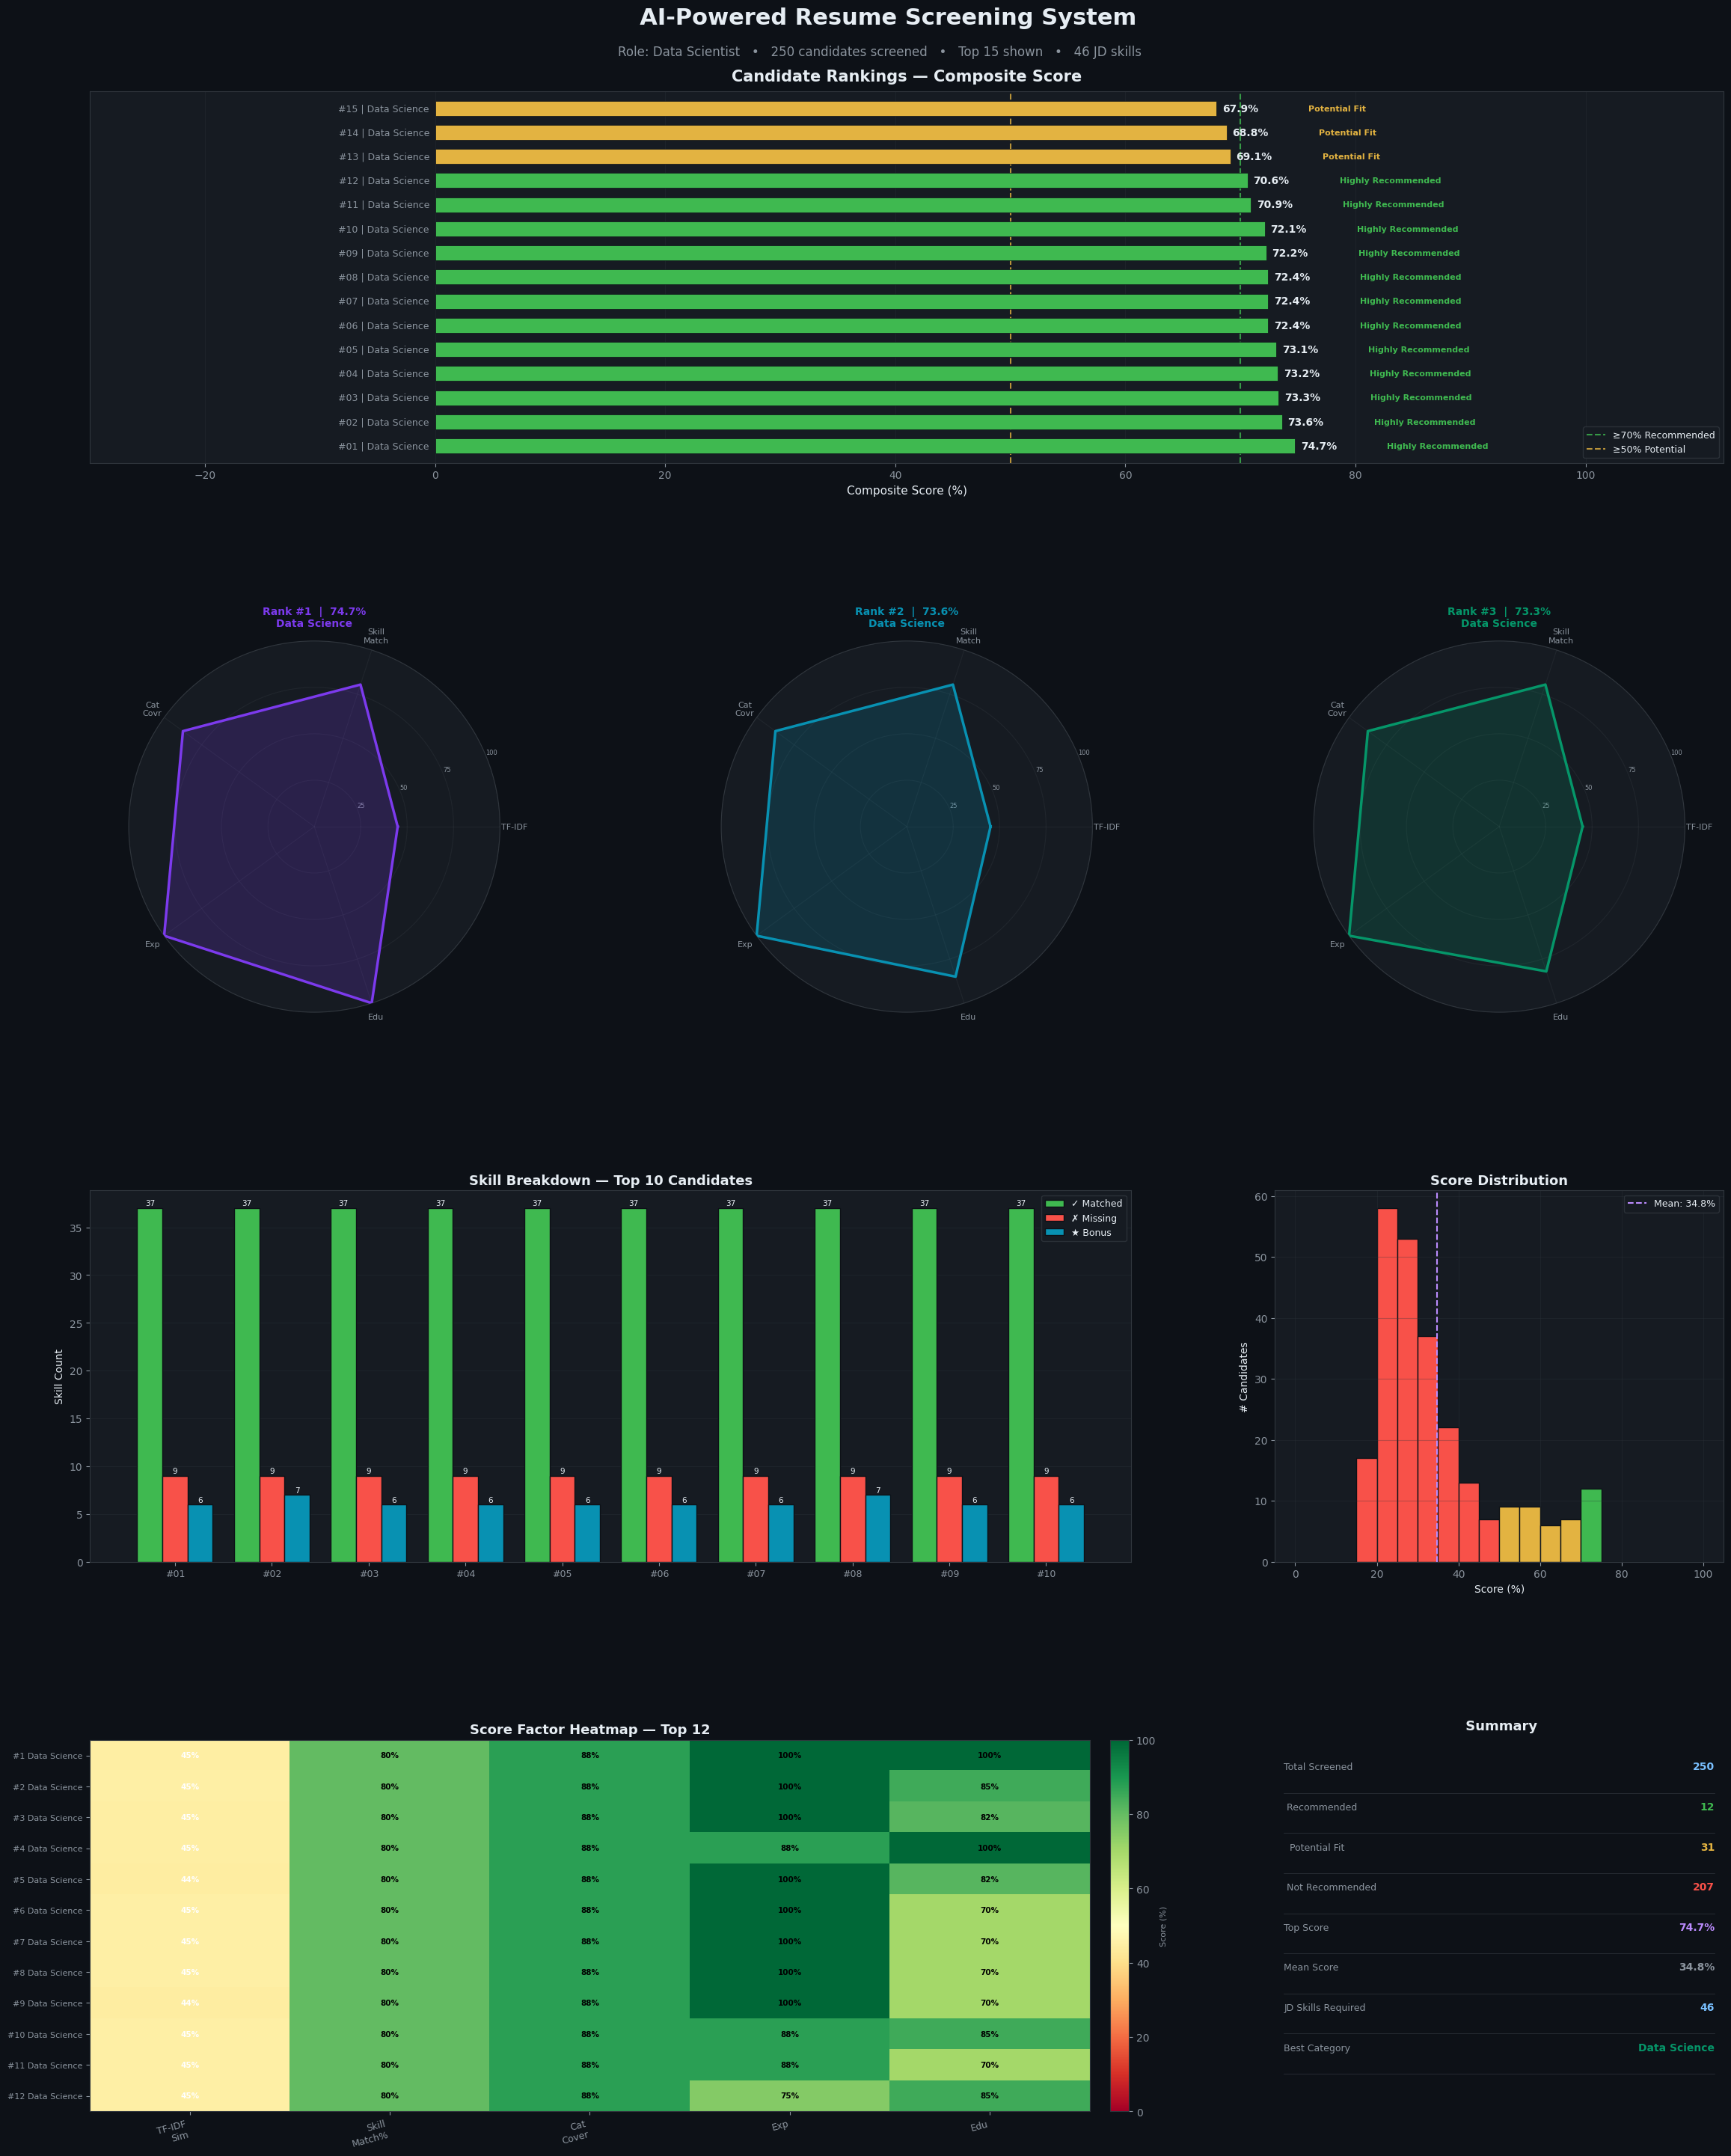

 Recruiter dashboard saved → recruiter_dashboard.png


In [ ]:
P = {"bg":"#0d1117","panel":"#161b22","border":"#30363d",
     "green":"#3fb950","yellow":"#e3b341","red":"#f85149",
     "accent1":"#7c3aed","accent2":"#0891b2","accent3":"#059669",
     "purple":"#bc8cff","blue":"#79c0ff","text":"#e6edf3","sub":"#8b949e"}
SC = {"Highly Recommended":"#3fb950","Potential Fit":"#e3b341","Not Recommended":"#f85149"}
def _st(s): return "Highly Recommended" if s>=70 else "Potential Fit" if s>=50 else "Not Recommended"

plt.rcParams.update({"font.family":"DejaVu Sans","text.color":P["text"],
    "axes.facecolor":P["panel"],"figure.facecolor":P["bg"],"axes.edgecolor":P["border"],
    "axes.labelcolor":P["text"],"xtick.color":P["sub"],"ytick.color":P["sub"],
    "grid.color":P["border"],"grid.alpha":0.4})

fig = plt.figure(figsize=(24, 30)); fig.patch.set_facecolor(P["bg"])
gs  = GridSpec(4, 3, figure=fig, hspace=0.48, wspace=0.32, top=0.94, bottom=0.04, left=0.06, right=0.97)
top15 = results_df.head(15).copy()

fig.text(0.5, 0.970, "  AI-Powered Resume Screening System",
         ha="center", fontsize=22, fontweight="bold", color=P["text"])
fig.text(0.5, 0.956,
         f"Role: {TARGET_ROLE}   •   {len(df_resume)} candidates screened   •   Top 15 shown   •   {len(pipeline.jd_skills)} JD skills",
         ha="center", fontsize=12, color=P["sub"])

# Panel 1: Ranking bar
ax1 = fig.add_subplot(gs[0, :]); ax1.set_facecolor(P["panel"])
labels_ = [f"#{int(r['rank']):02d} | {r['category'][:18]}" for _,r in top15.iterrows()]
scores_ = top15["composite_score"].tolist()
bars = ax1.barh(range(len(labels_)), scores_, color=[SC[_st(s)] for s in scores_],
                height=0.62, edgecolor=P["bg"], linewidth=0.5, zorder=3)
for i,(bar,s,(_,row)) in enumerate(zip(bars, scores_, top15.iterrows())):
    ax1.text(bar.get_width()+0.5, i, f"{s:.1f}%", va="center", fontsize=10, fontweight="bold", color=P["text"])
    ax1.text(-0.5, i, labels_[i], va="center", ha="right", fontsize=9, color=P["sub"])
    st = _st(s)
    ax1.text(bar.get_width()+8, i, st, va="center", fontsize=8, color=SC[st], fontweight="bold")
ax1.axvline(70, color=P["green"],  ls="--", lw=1.5, alpha=0.8, label="≥70% Recommended")
ax1.axvline(50, color=P["yellow"], ls="--", lw=1.5, alpha=0.8, label="≥50% Potential")
ax1.set_xlim(-30,112); ax1.set_ylim(-0.7, len(labels_)-0.3); ax1.set_yticks([])
ax1.set_xlabel("Composite Score (%)", fontsize=11)
ax1.set_title("Candidate Rankings — Composite Score", fontsize=15, fontweight="bold", color=P["text"], pad=10)
ax1.legend(loc="lower right", fontsize=9, facecolor=P["panel"], edgecolor=P["border"])
ax1.grid(axis="x", alpha=0.3, zorder=0)

# Panel 2: Radar (top 3)
fk = ["tfidf_score","skill_match_pct","category_pct","exp_score","edu_score"]
fl = ["TF-IDF","Skill\nMatch","Cat\nCovr","Exp","Edu"]
angles = [n/5*2*math.pi for n in range(5)] + [0]
for ci,(_,c) in enumerate(top15.head(3).iterrows()):
    ax = fig.add_subplot(gs[1,ci], polar=True)
    ax.set_facecolor(P["panel"]); ax.spines["polar"].set_color(P["border"])
    vals = [c[k] for k in fk] + [c[fk[0]]]
    col  = [P["accent1"],P["accent2"],P["accent3"]][ci]
    ax.plot(angles, vals, color=col, lw=2.5, zorder=3); ax.fill(angles, vals, color=col, alpha=0.2, zorder=2)
    ax.set_xticks(angles[:-1]); ax.set_xticklabels(fl, size=8, color=P["sub"])
    ax.set_ylim(0,100); ax.set_yticks([25,50,75,100]); ax.set_yticklabels(["25","50","75","100"],size=6,color=P["sub"])
    ax.grid(color=P["border"], alpha=0.4)
    ax.set_title(f"Rank #{int(c['rank'])}  |  {c['composite_score']:.1f}%\n{c['category'][:22]}",
                 size=10, fontweight="bold", color=col, pad=14)

# Panel 3: Skill breakdown bar
ax3 = fig.add_subplot(gs[2,:2]); ax3.set_facecolor(P["panel"])
t10 = results_df.head(10)
ids_ = [f"#{int(r['rank']):02d}" for _,r in t10.iterrows()]
xv = np.arange(len(ids_)); w = 0.26
for offset,key,lbl,col in [(-w,"matched_skills","✓ Matched",P["green"]),
                             (0,"missing_skills","✗ Missing",P["red"]),
                             (w,"bonus_skills","★ Bonus",P["accent2"])]:
    vals = [len(r[key]) for _,r in t10.iterrows()]
    bs = ax3.bar(xv+offset, vals, w, label=lbl, color=col, edgecolor=P["bg"], zorder=3)
    for b in bs:
        h = b.get_height()
        if h>0: ax3.text(b.get_x()+b.get_width()/2, h+0.1, str(int(h)), ha="center", va="bottom", fontsize=7.5, color=P["text"])
ax3.set_xticks(xv); ax3.set_xticklabels(ids_, fontsize=9)
ax3.set_ylabel("Skill Count", fontsize=10)
ax3.set_title("Skill Breakdown — Top 10 Candidates", fontsize=13, fontweight="bold", color=P["text"])
ax3.legend(fontsize=9, facecolor=P["panel"], edgecolor=P["border"]); ax3.grid(axis="y", alpha=0.3, zorder=0)

# Panel 4: Score distribution
ax4 = fig.add_subplot(gs[2,2]); ax4.set_facecolor(P["panel"])
bins = np.linspace(0,100,21)
_,_,patches = ax4.hist(results_df["composite_score"], bins=bins, edgecolor=P["bg"])
for patch in patches:
    mid = patch.get_x()+patch.get_width()/2
    patch.set_facecolor(P["green"] if mid>=70 else P["yellow"] if mid>=50 else P["red"])
ax4.axvline(results_df["composite_score"].mean(), color=P["purple"], ls="--", lw=1.5,
            label=f"Mean: {results_df['composite_score'].mean():.1f}%")
ax4.set_xlabel("Score (%)", fontsize=10); ax4.set_ylabel("# Candidates", fontsize=10)
ax4.set_title("Score Distribution", fontsize=13, fontweight="bold", color=P["text"])
ax4.legend(fontsize=9, facecolor=P["panel"], edgecolor=P["border"]); ax4.grid(alpha=0.3)

# Panel 5: Heatmap
ax5 = fig.add_subplot(gs[3,:2]); ax5.set_facecolor(P["panel"])
t12 = results_df.head(12)
heat = np.array([[r["tfidf_score"],r["skill_match_pct"],r["category_pct"],r["exp_score"],r["edu_score"]] for _,r in t12.iterrows()])
im = ax5.imshow(heat, cmap="RdYlGn", aspect="auto", vmin=0, vmax=100)
ax5.set_xticks(range(5)); ax5.set_xticklabels(["TF-IDF\nSim","Skill\nMatch%","Cat\nCover","Exp","Edu"],fontsize=9,rotation=15,ha="right")
ax5.set_yticks(range(12)); ax5.set_yticklabels([f"#{int(r['rank'])} {r['category'][:14]}" for _,r in t12.iterrows()], fontsize=8)
for i in range(12):
    for j in range(5):
        v=heat[i,j]; ax5.text(j,i,f"{v:.0f}%",ha="center",va="center",fontsize=7.5,fontweight="bold",color="black" if v>55 else "white")
cbar=plt.colorbar(im,ax=ax5,fraction=0.02,pad=0.02); cbar.set_label("Score (%)",color=P["sub"],fontsize=8)
cbar.ax.yaxis.set_tick_params(color=P["sub"]); plt.setp(cbar.ax.yaxis.get_ticklabels(),color=P["sub"])
ax5.set_title("Score Factor Heatmap — Top 12", fontsize=13, fontweight="bold", color=P["text"])

# Panel 6: Summary cards
ax6 = fig.add_subplot(gs[3,2]); ax6.set_facecolor(P["panel"]); ax6.axis("off")
rec_=(results_df["composite_score"]>=70).sum(); pot_=((results_df["composite_score"]>=50)&(results_df["composite_score"]<70)).sum()
stats=[("Total Screened",str(len(results_df)),P["blue"]),(" Recommended",str(rec_),P["green"]),
       ("  Potential Fit",str(pot_),P["yellow"]),(" Not Recommended",str((results_df["composite_score"]<50).sum()),P["red"]),
       ("Top Score",f"{results_df['composite_score'].max():.1f}%",P["purple"]),
       ("Mean Score",f"{results_df['composite_score'].mean():.1f}%",P["sub"]),
       ("JD Skills Required",str(len(pipeline.jd_skills)),P["blue"]),
       ("Best Category",results_df.iloc[0]["category"][:18],P["accent3"])]
ax6.set_title(" Summary", fontsize=13, fontweight="bold", color=P["text"], pad=10)
y=0.92
for lbl,val,col in stats:
    ax6.text(0.02,y,lbl,transform=ax6.transAxes,fontsize=9,color=P["sub"])
    ax6.text(0.98,y,val,transform=ax6.transAxes,fontsize=10,fontweight="bold",color=col,ha="right")
    y-=0.108
    ax6.plot([0.02,0.98],[y+0.045,y+0.045],color=P["border"],linewidth=0.5,transform=ax6.transAxes,clip_on=False)

plt.savefig("recruiter_dashboard.png", dpi=150, bbox_inches="tight", facecolor=P["bg"])
plt.show()
print(" Recruiter dashboard saved → recruiter_dashboard.png")

Step 11 — Skill Gap Heatmap Matrix

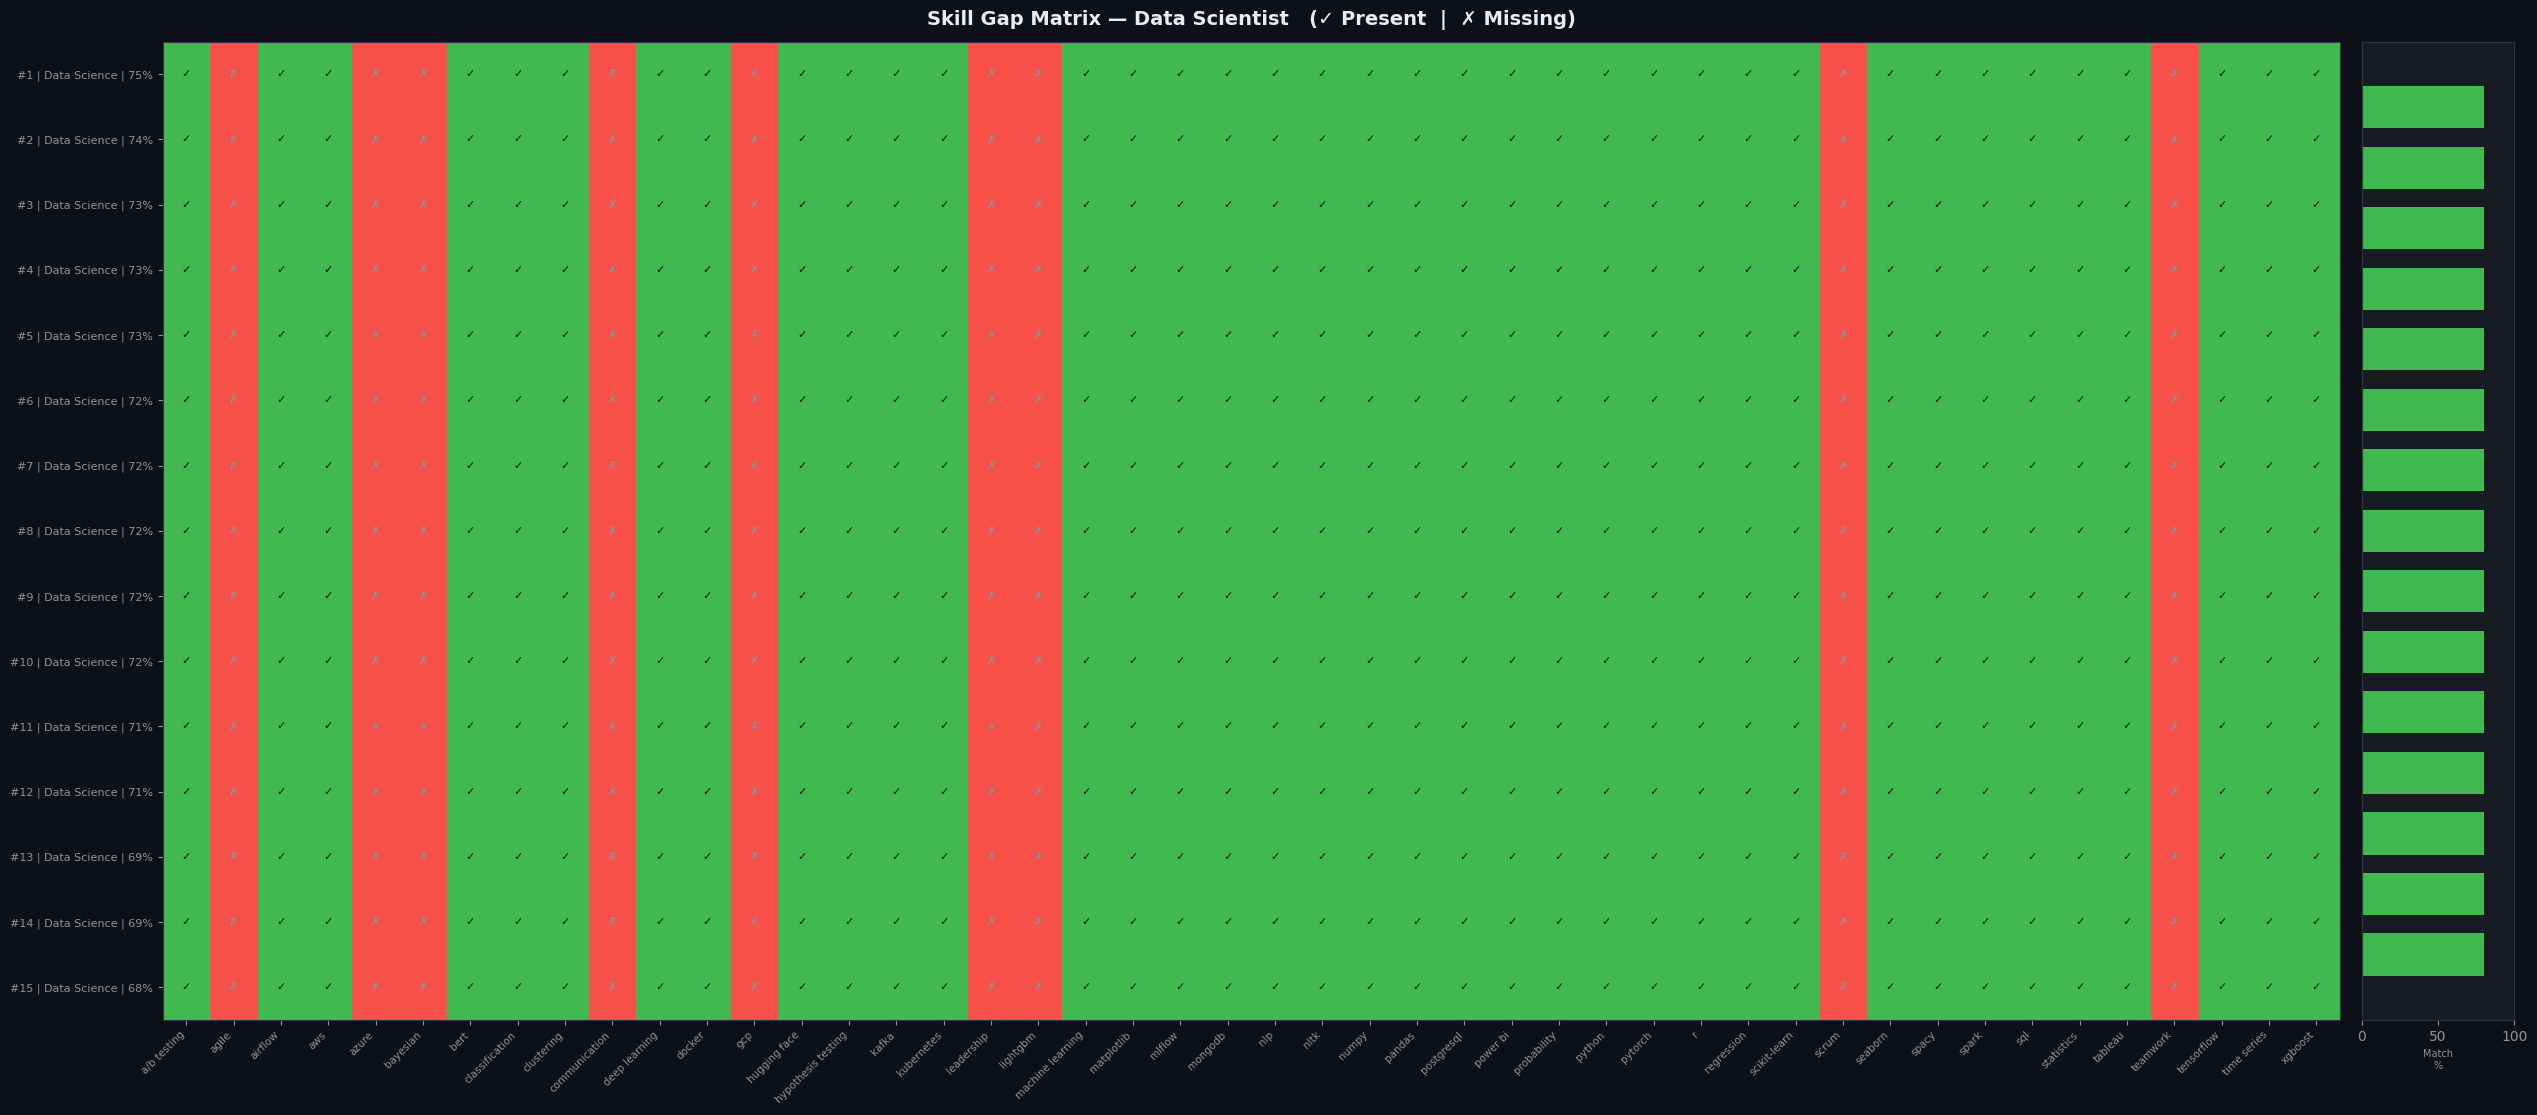

 Skill gap heatmap saved → skill_gap_heatmap.png


In [ ]:
TOP_N_GAP = min(15, len(results_df))
top_gap   = results_df.head(TOP_N_GAP)
req_list  = sorted(pipeline.jd_skills.keys())

matrix = np.zeros((TOP_N_GAP, len(req_list)))
for i,(_,row) in enumerate(top_gap.iterrows()):
    ms = set(row["matched_skills"]) if isinstance(row["matched_skills"], list) else set()
    for j,sk in enumerate(req_list):
        matrix[i,j] = 1 if sk in ms else 0

fig, ax = plt.subplots(figsize=(max(16, len(req_list)*0.55), max(8, TOP_N_GAP*0.55+3)))
fig.patch.set_facecolor(P["bg"]); ax.set_facecolor(P["panel"])

cmap_gap = mcolors.LinearSegmentedColormap.from_list("gap",[P["red"],P["panel"],P["green"]])
ax.imshow(matrix, cmap=cmap_gap, aspect="auto", vmin=0, vmax=1)
for i in range(TOP_N_GAP):
    for j in range(len(req_list)):
        sym="✓" if matrix[i,j]==1 else "✗"
        ax.text(j,i,sym,ha="center",va="center",fontsize=8,
                color=P["bg"] if matrix[i,j]==1 else P["sub"],fontweight="bold")

ax.set_xticks(range(len(req_list)))
ax.set_xticklabels(req_list, rotation=45, ha="right", fontsize=7.5, color=P["sub"])
ax.set_yticks(range(TOP_N_GAP))
ax.set_yticklabels([f"#{int(r['rank'])} | {r['category'][:16]} | {r['composite_score']:.0f}%"
                    for _,r in top_gap.iterrows()], fontsize=8)
ax.set_title(f"Skill Gap Matrix — {TARGET_ROLE}   (✓ Present  |  ✗ Missing)",
             fontsize=14, fontweight="bold", color=P["text"], pad=12)

ax_r = ax.inset_axes([1.01,0,0.07,1])
cov = matrix.mean(axis=1)*100
ax_r.barh(range(TOP_N_GAP), cov,
          color=[P["green"] if c>=70 else P["yellow"] if c>=50 else P["red"] for c in cov], height=0.7)
ax_r.set_xlim(0,100); ax_r.set_yticks([]); ax_r.set_xlabel("Match\n%",fontsize=7,color=P["sub"])
ax_r.set_facecolor(P["panel"])
for sp in ax_r.spines.values(): sp.set_color(P["border"])
ax_r.tick_params(colors=P["sub"])

plt.tight_layout()
plt.savefig("skill_gap_heatmap.png", dpi=140, bbox_inches="tight", facecolor=P["bg"])
plt.show()
print(" Skill gap heatmap saved → skill_gap_heatmap.png")

Step 12 — Analytics Deep-Dive (4 Charts)

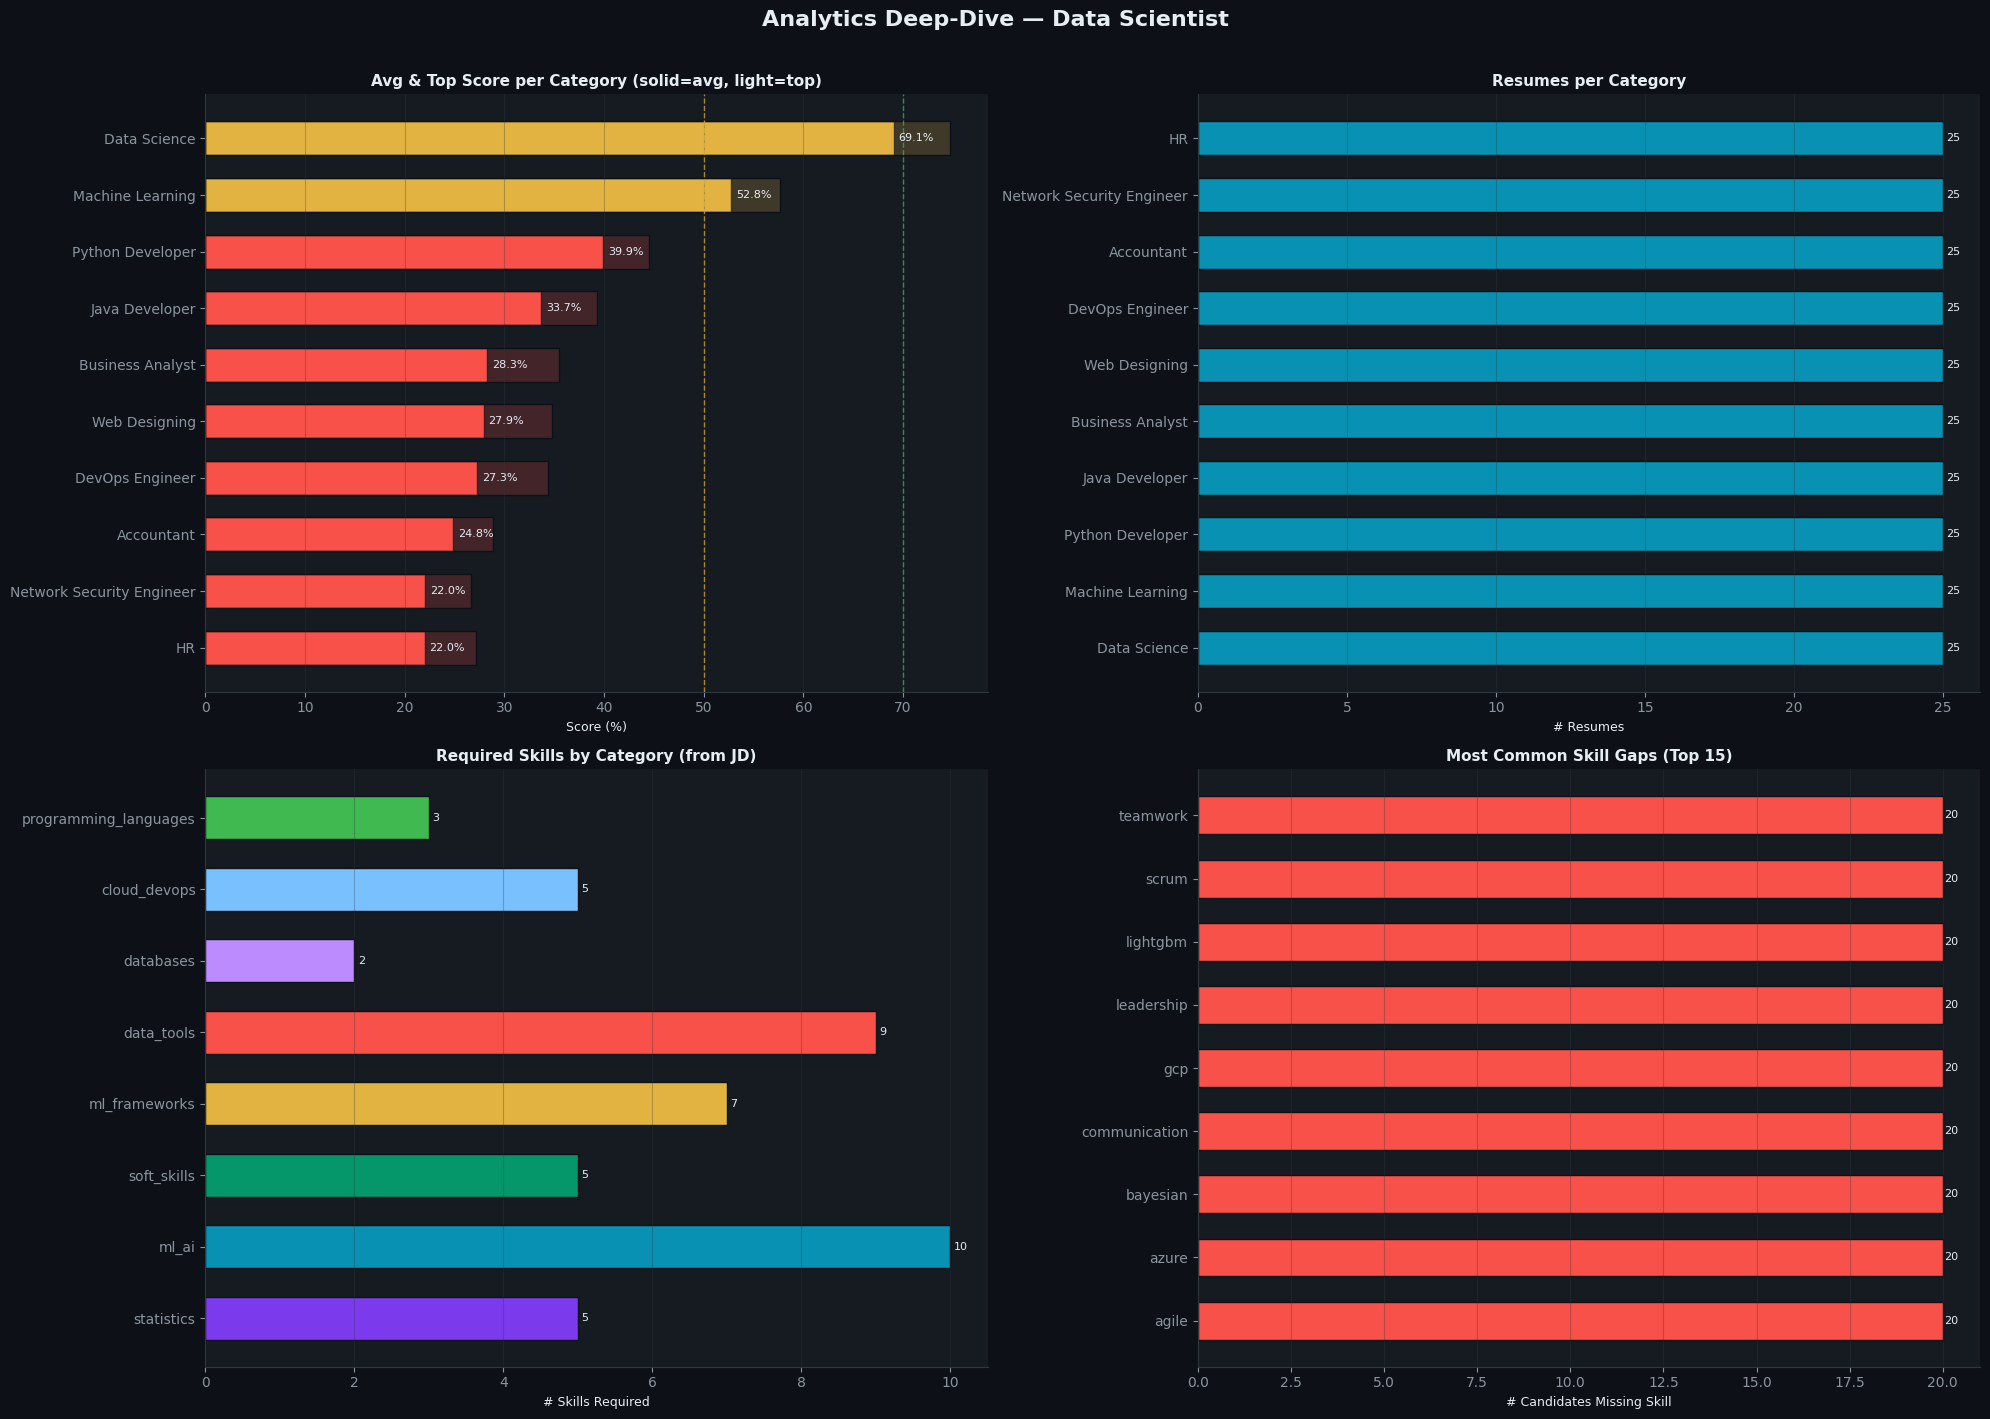

 Analytics chart saved → analytics_deep_dive.png


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.patch.set_facecolor(P["bg"])
fig.suptitle(f"Analytics Deep-Dive — {TARGET_ROLE}", fontsize=16, fontweight="bold", color=P["text"], y=1.01)

# (0,0) Category avg score
ax = axes[0][0]; ax.set_facecolor(P["panel"])
cs = cat_lb.sort_values("avg_score", ascending=True)
bcs = [P["green"] if s>=70 else P["yellow"] if s>=50 else P["red"] for s in cs["avg_score"]]
ax.barh(cs.index, cs["avg_score"],   color=bcs,           height=0.6, edgecolor=P["bg"])
ax.barh(cs.index, cs["top_score"],   color=[c+"33" for c in bcs], height=0.6, edgecolor=P["bg"])
for _,(cat,row) in enumerate(cs.iterrows()):
    ax.text(row["avg_score"]+0.5, cat, f"{row['avg_score']:.1f}%", va="center", fontsize=8, color=P["text"])
ax.axvline(50,color=P["yellow"],ls="--",lw=1,alpha=0.7); ax.axvline(70,color=P["green"],ls="--",lw=1,alpha=0.7)
ax.set_xlabel("Score (%)", fontsize=9); ax.grid(axis="x", alpha=0.3)
ax.set_title("Avg & Top Score per Category (solid=avg, light=top)", fontsize=11, fontweight="bold", color=P["text"])

# (0,1) Resumes per category
ax = axes[0][1]; ax.set_facecolor(P["panel"])
cn = cat_lb.sort_values("n_resumes", ascending=True)
ax.barh(cn.index, cn["n_resumes"], color=P["accent2"], height=0.6, edgecolor=P["bg"])
for _,(cat,row) in enumerate(cn.iterrows()):
    ax.text(row["n_resumes"]+0.1, cat, str(int(row["n_resumes"])), va="center", fontsize=8, color=P["text"])
ax.set_xlabel("# Resumes", fontsize=9); ax.grid(axis="x", alpha=0.3)
ax.set_title("Resumes per Category", fontsize=11, fontweight="bold", color=P["text"])

# (1,0) JD skill category breakdown
ax = axes[1][0]; ax.set_facecolor(P["panel"])
cc = Counter(pipeline.jd_skills.values())
pie_cols=[P["accent1"],P["accent2"],P["accent3"],P["yellow"],P["red"],P["purple"],P["blue"],P["green"],P["sub"]]
ax.barh(list(cc.keys()), list(cc.values()), color=pie_cols[:len(cc)], height=0.6, edgecolor=P["bg"])
for c,f in cc.items():
    ax.text(f+0.05, c, str(f), va="center", fontsize=8, color=P["text"])
ax.set_xlabel("# Skills Required", fontsize=9); ax.grid(axis="x", alpha=0.3)
ax.set_title("Required Skills by Category (from JD)", fontsize=11, fontweight="bold", color=P["text"])

# (1,1) Top skill gaps
ax = axes[1][1]; ax.set_facecolor(P["panel"])
tg = gap_df.head(15)
ax.barh(tg["skill"], tg["frequency"], color=P["red"], height=0.6, edgecolor=P["bg"])
for _,row in tg.iterrows():
    ax.text(row["frequency"]+0.05, row["skill"], str(int(row["frequency"])), va="center", fontsize=8, color=P["text"])
ax.set_xlabel("# Candidates Missing Skill", fontsize=9); ax.grid(axis="x", alpha=0.3)
ax.set_title("Most Common Skill Gaps (Top 15)", fontsize=11, fontweight="bold", color=P["text"])

for a in axes.flat: a.spines[["top","right"]].set_visible(False)
plt.tight_layout()
plt.savefig("analytics_deep_dive.png", dpi=140, bbox_inches="tight", facecolor=P["bg"])
plt.show()
print(" Analytics chart saved → analytics_deep_dive.png")

Step 13 — Multi-Role Comparison


   Role     : Data Scientist
   JD Skills: 46 across 8 categories
  Resumes  : 250 to screen

    Screening 250 resumes...
   Done!  Top: 74.7% |  12  ⚠️ 31   207

   Role     : Machine Learning Engineer
   JD Skills: 30 across 6 categories
  Resumes  : 250 to screen

    Screening 250 resumes...
   Done!  Top: 78.7% |  19  ⚠️ 18   213

   Role     : Full Stack Developer
   JD Skills: 28 across 5 categories
  Resumes  : 250 to screen

    Screening 250 resumes...
   Done!  Top: 76.7% |  10  ⚠️ 53   187

   Role     : DevOps Engineer
   JD Skills: 21 across 3 categories
  Resumes  : 250 to screen

    Screening 250 resumes...
   Done!  Top: 68.0% |  0  ⚠️ 71   179

   Role     : Data Analyst
   JD Skills: 19 across 6 categories
  Resumes  : 250 to screen

    Screening 250 resumes...
   Done!  Top: 63.0% |  0  ⚠️ 25   225

   Role     : Software Engineer
   JD Skills: 19 across 5 categories
  Resumes  : 250 to screen

    Screening 250 resumes...
   Done!  Top: 66.8% |  0  ⚠️ 99   151


,Role,Top Score,Mean Score,Std Dev,Recommended,Potential,JD Skills
5,Software Engineer,66.800000,42.300000,14.300000,0,99,19
3,DevOps Engineer,68.000000,40.900000,13.080000,0,71,21
2,Full Stack Developer,76.710000,38.640000,15.720000,10,53,28
1,Machine Learning Engineer,78.710000,37.260000,15.470000,19,18,30
0,Data Scientist,74.740000,34.780000,14.970000,12,31,46
4,Data Analyst,63.030000,34.510000,10.630000,0,25,19


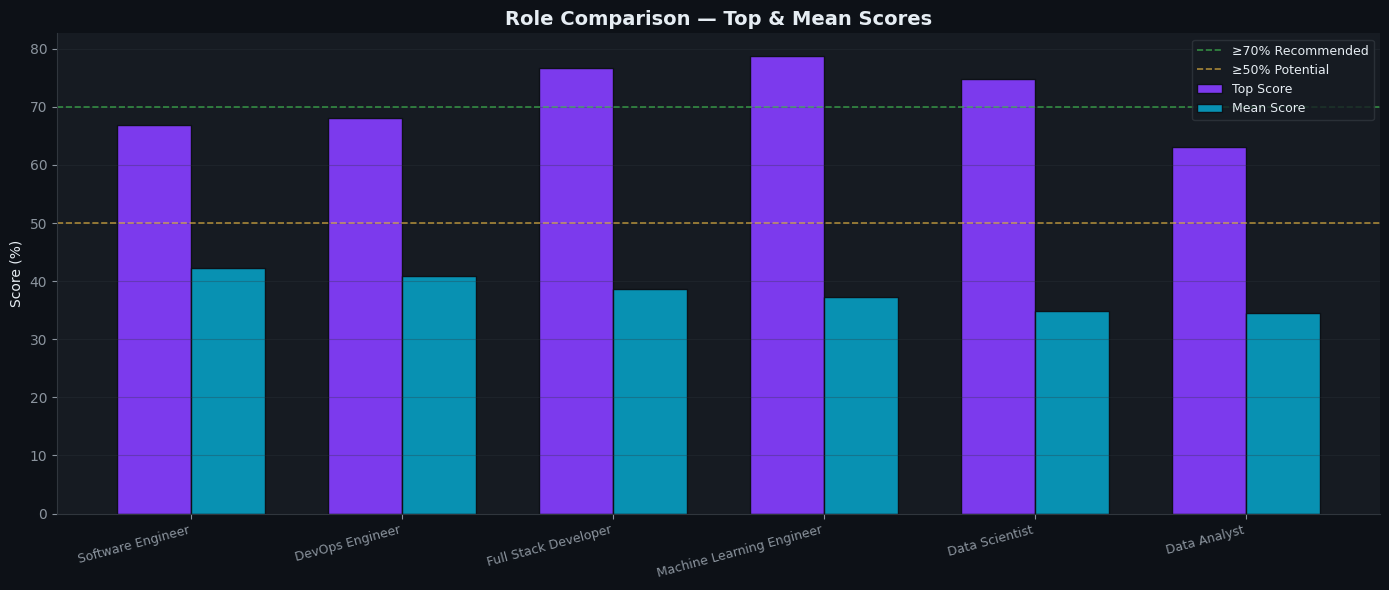

 Role comparison chart saved → role_comparison.png


In [ ]:
comparison_rows = []
for role in df_jd["Job Title"].dropna().unique()[:6]:
    try:
        p = ResumeScreeningPipeline(role, df_jd, df_resume)
        r = p.run()
        comparison_rows.append({"Role": role,
            "Top Score": r["composite_score"].max(),
            "Mean Score": round(r["composite_score"].mean(), 2),
            "Std Dev": round(r["composite_score"].std(), 2),
            " Recommended": (r["composite_score"]>=70).sum(),
            " Potential": ((r["composite_score"]>=50)&(r["composite_score"]<70)).sum(),
            "JD Skills": len(p.jd_skills)})
    except Exception as e: print(f"Skipping '{role}': {e}")

cmp_df = pd.DataFrame(comparison_rows).sort_values("Mean Score", ascending=False)
display(cmp_df.style.background_gradient(subset=["Mean Score","Top Score"], cmap="RdYlGn"))

fig, ax = plt.subplots(figsize=(14, 6)); fig.patch.set_facecolor(P["bg"]); ax.set_facecolor(P["panel"])
x = np.arange(len(cmp_df)); w = 0.35
ax.bar(x-w/2, cmp_df["Top Score"],  w, label="Top Score",  color=P["accent1"], edgecolor=P["bg"])
ax.bar(x+w/2, cmp_df["Mean Score"], w, label="Mean Score", color=P["accent2"], edgecolor=P["bg"])
ax.set_xticks(x); ax.set_xticklabels(cmp_df["Role"], rotation=15, ha="right", fontsize=9)
ax.set_ylabel("Score (%)", fontsize=10)
ax.set_title("Role Comparison — Top & Mean Scores", fontsize=14, fontweight="bold", color=P["text"])
ax.axhline(70, color=P["green"],  ls="--", lw=1.2, alpha=0.7, label="≥70% Recommended")
ax.axhline(50, color=P["yellow"], ls="--", lw=1.2, alpha=0.7, label="≥50% Potential")
ax.legend(fontsize=9, facecolor=P["panel"], edgecolor=P["border"])
ax.grid(axis="y", alpha=0.3); ax.spines[["top","right"]].set_visible(False)
plt.tight_layout()
plt.savefig("role_comparison.png", dpi=140, bbox_inches="tight", facecolor=P["bg"])
plt.show()
print(" Role comparison chart saved → role_comparison.png")

Step 14 — Export CSV & Download All Files

In [ ]:
# Export results to CSV
csv_name = TARGET_ROLE.replace(" ","_") + "_screening_results.csv"
results_df[["rank","resume_id","category","composite_score","status",
            "est_years_exp","tfidf_score","skill_match_pct","category_pct",
            "exp_score","edu_score","total_skills","matched_skills",
            "missing_skills","bonus_skills","snippet"]].to_csv(csv_name, index=False)
print(f" Results exported → {csv_name}  ({len(results_df)} rows)")

# Auto-download all outputs in Colab
try:
    from google.colab import files as colab_files
    for fname in [csv_name, "recruiter_dashboard.png", "skill_gap_heatmap.png",
                  "analytics_deep_dive.png", "role_comparison.png"]:
        colab_files.download(fname)
    print(" All files downloaded to your machine")
except ImportError:
    print("Not in Colab — files saved in current working directory")

print("\n" + "="*65)
print("    ALL DONE!")
print("="*65)
print(f"  Role          : {TARGET_ROLE}")
print(f"  Total Screened: {len(results_df)}")
print(f"   Recommended : {(results_df['composite_score']>=70).sum()}")
print(f"    Potential  : {((results_df['composite_score']>=50)&(results_df['composite_score']<70)).sum()}")
print(f"   Not Rec.   : {(results_df['composite_score']<50).sum()}")
print(f"  Top Score     : {results_df['composite_score'].max():.1f}%")
print(f"  Mean Score    : {results_df['composite_score'].mean():.1f}%")
print("="*65)

 Results exported → Data_Scientist_screening_results.csv  (250 rows)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 All files downloaded to your machine

    ALL DONE!
  Role          : Data Scientist
  Total Screened: 250
   Recommended : 12
    Potential  : 31
   Not Rec.   : 207
  Top Score     : 74.7%
  Mean Score    : 34.8%


---

# 📄 BONUS — Single Resume Analyzer & Report Generator

> Upload **your own resume** (PDF or TXT) and get a detailed personal screening report  
> with skill matching, score breakdown, gap analysis, and a visual dashboard — all in one click.

**Supported formats:** `.pdf` · `.txt` · `.docx`  



Install PDF Support & Upload Your Resume

In [ ]:
# Install PDF reader (only needed for .pdf uploads)
import subprocess
subprocess.run(["pip", "install", "-q", "pdfplumber"], capture_output=True)

import pdfplumber
import io

print(" PDF support ready")
print()
print("━"*60)
print("    SINGLE RESUME ANALYZER")
print("━"*60)
print("""
  Upload your resume in any of these formats:
    • PDF  (.pdf)
    • Text (.txt)
    • Word (.docx)  ← plain text extraction

  The system will:
      Extract all text from your resume
      Detect skills using the 148-skill taxonomy
      Score against every job role in the JD dataset
      Find your best-matching role automatically
      Generate a detailed personal report
      Create a visual dashboard (charts + radar)
      List missing skills per role (gap analysis)
      Download a PDF-style text report
""")
print("━"*60)

# Upload
RESUME_TEXT = None
RESUME_FILENAME = None

try:
    from google.colab import files as colab_files
    print("\n  → Upload your resume file now:\n")
    uploaded_resume = colab_files.upload()

    for fname, content in uploaded_resume.items():
        RESUME_FILENAME = fname
        ext = fname.lower().split(".")[-1]

        # PDF extraction
        if ext == "pdf":
            text_parts = []
            with pdfplumber.open(io.BytesIO(content)) as pdf:
                for page in pdf.pages:
                    t = page.extract_text()
                    if t:
                        text_parts.append(t)
            RESUME_TEXT = "\n".join(text_parts)
            print(f"   PDF parsed  : {fname}  ({len(RESUME_TEXT):,} chars, {len(text_parts)} pages)")

        # DOCX extraction (basic)
        elif ext == "docx":
            try:
                import zipfile, xml.etree.ElementTree as ET
                with zipfile.ZipFile(io.BytesIO(content)) as z:
                    with z.open("word/document.xml") as doc_xml:
                        tree = ET.parse(doc_xml)
                        ns = {"w": "http://schemas.openxmlformats.org/wordprocessingml/2006/main"}
                        paras = tree.findall(".//w:p", ns)
                        lines = []
                        for p in paras:
                            runs = p.findall(".//w:t", ns)
                            line = " ".join(r.text for r in runs if r.text)
                            if line.strip():
                                lines.append(line.strip())
                RESUME_TEXT = "\n".join(lines)
                print(f"   DOCX parsed : {fname}  ({len(RESUME_TEXT):,} chars)")
            except Exception as e:
                RESUME_TEXT = content.decode("utf-8", errors="ignore")
                print(f"    DOCX fallback to raw text: {e}")

        # Plain text
        else:
            RESUME_TEXT = content.decode("utf-8", errors="ignore")
            print(f"   TXT loaded  : {fname}  ({len(RESUME_TEXT):,} chars)")

except ImportError:
    print("  Not in Colab — using a sample resume for demo")
    RESUME_TEXT = """
    John Doe | john.doe@email.com | linkedin.com/in/johndoe
    SUMMARY: Data Scientist with 4 years experience in machine learning,
    Python, NLP, TensorFlow, PyTorch, and statistical modeling.
    EXPERIENCE: Data Scientist — Google (4 years)
    Built deep learning models with TensorFlow and PyTorch for NLP tasks.
    Applied BERT and Hugging Face transformers for text classification.
    Used Pandas, NumPy, Scikit-learn, XGBoost for data analysis.
    Deployed models on AWS using Docker, Kubernetes, and MLflow.
    Statistical analysis: regression, classification, clustering, A/B testing.
    Databases: PostgreSQL, MongoDB, Spark.
    SKILLS: Python, SQL, TensorFlow, PyTorch, Scikit-learn, XGBoost, Pandas,
    NumPy, Matplotlib, AWS, Docker, Git, MLflow, BERT, NLP, Machine Learning,
    Deep Learning, Statistics, PostgreSQL, MongoDB, Jupyter, Linux
    EDUCATION: M.S. Computer Science
    """
    RESUME_FILENAME = "sample_resume.txt"
    print(f"   Demo resume loaded ({len(RESUME_TEXT):,} chars)")

if RESUME_TEXT:
    print(f"\n  Preview (first 300 chars):")
    print("  " + RESUME_TEXT[:300].replace("\n", "\n  "))


 PDF support ready

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    SINGLE RESUME ANALYZER
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Upload your resume in any of these formats:
    • PDF  (.pdf)
    • Text (.txt)
    • Word (.docx)  ← plain text extraction

  The system will:
      Extract all text from your resume
      Detect skills using the 148-skill taxonomy
      Score against every job role in the JD dataset
      Find your best-matching role automatically
      Generate a detailed personal report
      Create a visual dashboard (charts + radar)
      List missing skills per role (gap analysis)
      Download a PDF-style text report

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  → Upload your resume file now:



Saving VIBHU'S PERFECT ATS RESUME.pdf to VIBHU'S PERFECT ATS RESUME.pdf
   PDF parsed  : VIBHU'S PERFECT ATS RESUME.pdf  (4,191 chars, 2 pages)

  Preview (first 300 chars):
  V.VIBHUDESWAR REDDY
  9550692578 | vibhudeswar3@gmail.com | https://github.com/vibhudeswarReddy | https://www.linkedin.com/in/vibhudeswar-reddy/
  EDUCATION
  Alliance University, Bengaluru, Karnataka Aug 2023 - Present
  B.Tech in Computer Science and Engineering (AIML)
  CGPA : 9.0
  Relevant Courses: Supervi


Analyze Resume Against All Roles

In [ ]:
import re
import pandas as pd # Import pandas
import random # Import random for synthetic data generation

#  Data Loading and Synthetic Data Generation
COMPANIES = ["Google","Meta","Amazon","Microsoft","Apple","Netflix","Uber","Airbnb",
             "Stripe","Salesforce","IBM","Oracle","Adobe","Spotify","Nvidia","Intel",
             "Palantir","Snowflake","Databricks","OpenAI"]
LOCATIONS  = ["San Francisco, CA","New York, NY","Seattle, WA","Austin, TX",
              "Boston, MA","Chicago, IL","Los Angeles, CA","Remote"]
NAMES      = [("Alice Johnson","alice.j@email.com"),("Bob Martinez","bob.m@email.com"),
              ("Carol White","carol.w@email.com"),  ("David Kim","david.k@email.com"),
              ("Emma Wilson","emma.w@email.com"),   ("Frank Chen","frank.c@email.com"),
              ("Grace Patel","grace.p@email.com"),  ("Henry Brown","henry.b@email.com"),
              ("Iris Davis","iris.d@email.com"),    ("James Garcia","james.g@email.com"),
              ("Karen Lee","karen.l@email.com"),    ("Liam Taylor","liam.t@email.com"),
              ("Maya Singh","maya.s@email.com"),    ("Noah Anderson","noah.a@email.com"),
              ("Olivia Thomas","olivia.t@email.com"),("Peter Jackson","peter.j@email.com"),
              ("Quinn Harris","quinn.h@email.com"), ("Rachel Lopez","rachel.l@email.com"),
              ("Sam Walker","sam.w@email.com"),     ("Tina Hall","tina.h@email.com")]
EDUS = ["B.S.","B.E.","M.S.","M.Tech.","Ph.D.","MBA"]

RESUME_TEMPLATES = {
"Data Science": """{name} | {email}
SUMMARY: Data Scientist with {exp} years experience in machine learning, Python,
NLP, and statistical modeling. Proven track record deploying predictive models.
EXPERIENCE: Senior Data Scientist — {company} ({exp} years)
• Machine learning: TensorFlow, PyTorch, Scikit-learn, XGBoost, gradient boosting
• NLP pipelines: BERT, Hugging Face transformers, spaCy, NLTK, deep learning
• Neural networks: classification, clustering, regression, time series, A/B testing
• Data tools: Pandas, NumPy, Matplotlib, Seaborn, Tableau, Power BI, Jupyter
• Cloud & MLOps: AWS, Docker, Kubernetes, MLflow, Airflow, Spark, Kafka
• Databases: PostgreSQL, MongoDB; Statistics, Hypothesis testing, Probability
SKILLS: Python, R, SQL, TensorFlow, PyTorch, Scikit-learn, Keras, XGBoost,
Pandas, NumPy, Matplotlib, Seaborn, Tableau, Power BI, Spark, AWS, Docker,
Kubernetes, Git, MLflow, NLTK, spaCy, Machine Learning, Deep Learning, NLP,
Regression, Classification, Clustering, A/B Testing, Hypothesis Testing,
PostgreSQL, MongoDB, Airflow, Statistics, Probability, Linux
EDUCATION: {edu} Computer Science / Data Science""",

"Machine Learning": """{name} | {email}
ML ENGINEER — {exp} YEARS
EXPERIENCE: ML Engineer — {company}
• Production ML: PyTorch, TensorFlow, Keras, XGBoost, LightGBM, Scikit-learn
• MLOps: MLflow, Kubeflow, Airflow, Ray; deep learning: CNNs, RNNs, Transformers
• NLP, computer vision, reinforcement learning; Hugging Face, BERT, GPT
• Distributed training: Spark, Kafka on AWS, GCP, Azure; Docker, Kubernetes
• CI/CD: Jenkins, GitLab; Linux system administration
SKILLS: Python, Scala, SQL, Bash, TensorFlow, PyTorch, Scikit-learn, XGBoost,
Hugging Face, MLflow, Kubeflow, Airflow, Ray, AWS, GCP, Azure, Docker,
Kubernetes, Terraform, Spark, Kafka, Redis, PostgreSQL, MongoDB,
Machine Learning, Deep Learning, NLP, Computer Vision, Git, Linux, CI/CD, Agile
EDUCATION: {edu} Computer Science / Electrical Engineering""",

"Web Designing": """{name} | {email}
Full Stack Developer — {exp} years
EXPERIENCE: Senior Developer — {company}
• Frontend: React, Angular, Vue.js, TypeScript, JavaScript, HTML5, CSS3, SASS
• Backend: Node.js, Django, Flask, FastAPI, Spring Boot; REST API, GraphQL
• Databases: MySQL, PostgreSQL, MongoDB, Redis, Firebase
• Cloud & DevOps: AWS, Docker, Kubernetes, Jenkins, CI/CD, Git
• Microservices architecture; Agile/Scrum
SKILLS: React, Angular, Vue, JavaScript, TypeScript, HTML, CSS, SASS,
Node.js, Django, Flask, FastAPI, Spring Boot, MySQL, PostgreSQL, MongoDB,
Redis, Firebase, AWS, Docker, Kubernetes, Jenkins, CI/CD, Git,
GraphQL, REST API, Microservices, Agile, Scrum, Linux
EDUCATION: {edu} Computer Science / Software Engineering""",

"Java Developer": """{name} | {email}
Java Software Engineer — {exp} years
EXPERIENCE: Senior Java Developer — {company}
• Enterprise apps: Java, Spring Boot, Hibernate, Maven; REST API, microservices
• Databases: MySQL, PostgreSQL, Oracle, MongoDB, Redis; Kafka, RabbitMQ
• AWS: EC2, S3, RDS, Lambda; Docker, Kubernetes; Jenkins CI/CD
• Testing: JUnit, Mockito; Git version control; Agile/Scrum
SKILLS: Java, Python, SQL, Spring Boot, Spring Cloud, Hibernate, MySQL,
PostgreSQL, Oracle, MongoDB, Redis, AWS, Docker, Kubernetes, Jenkins,
CI/CD, Git, Kafka, RabbitMQ, REST API, Microservices, JUnit, Mockito, Agile
EDUCATION: {edu} Computer Science""",

"Python Developer": """{name} | {email}
Python Software Developer — {exp} years
EXPERIENCE: Python Developer — {company}
• Backend services: Django, Flask, FastAPI; data pipelines: Pandas, NumPy, PySpark
• Async queues: Celery, Redis; databases: PostgreSQL, MySQL, MongoDB, Elasticsearch
• Docker, Kubernetes on AWS and GCP; REST APIs, GraphQL endpoints
• Clean Python: pytest, PEP8, type hints; Git, CI/CD
SKILLS: Python, SQL, JavaScript, Bash, Django, Flask, FastAPI, Celery,
SQLAlchemy, Pandas, NumPy, Matplotlib, Scikit-learn, PostgreSQL, MySQL,
MongoDB, Redis, Elasticsearch, AWS, GCP, Docker, Kubernetes, Jenkins,
CI/CD, Git, Agile, Pytest, Linux
EDUCATION: {edu} Computer Science / Software Engineering""",

"DevOps Engineer": """{name} | {email}
DevOps / Cloud Engineer — {exp} years
EXPERIENCE: Senior DevOps Engineer — {company}
• Cloud IaC: AWS, GCP, Azure; Terraform, Ansible, CloudFormation
• Kubernetes clusters, Helm charts, Docker containerization
• CI/CD: Jenkins, GitLab, GitHub Actions, ArgoCD
• Monitoring: Prometheus, Grafana, ELK Stack, Datadog
• Bash, Python, Go automation; IAM, VPC, Vault secrets; Linux admin
SKILLS: AWS, GCP, Azure, Terraform, Ansible, CloudFormation, Helm, Jenkins,
GitLab, GitHub Actions, ArgoCD, Docker, Kubernetes, Prometheus, Grafana,
ELK, Datadog, Bash, Python, Go, SQL, PostgreSQL, MySQL, MongoDB, Redis,
IAM, Linux, Unix, Git, CI/CD
EDUCATION: {edu} Computer Science / Information Systems""",

"HR": """{name} | {email}
Human Resources Manager — {exp} years
EXPERIENCE: HR Manager — {company}
• Full-cycle recruitment, employee relations, performance management
• HRIS: Workday, SAP SuccessFactors, BambooHR, ADP
• Training programs, diversity & inclusion, compliance, labor law
• Compensation & benefits, payroll coordination, conflict resolution
• Excel, PowerPoint, Tableau for HR analytics
SKILLS: Recruitment, Talent Acquisition, Employee Relations,
Performance Management, Workday, SAP SuccessFactors, BambooHR,
Training Development, Compensation Benefits, Compliance, Labor Law,
Diversity Inclusion, Excel, PowerPoint, Tableau,
Communication, Leadership, Negotiation, Problem Solving
EDUCATION: {edu} Human Resources / Business Administration""",

"Accountant": """{name} | {email}
Certified Accountant (CPA) — {exp} years
EXPERIENCE: Senior Accountant — {company}
• Financial statements: P&L, Balance Sheet, Cash Flow — GAAP/IFRS
• AR/AP, general ledger, internal/external audits; tax compliance
• Accounting software: QuickBooks, SAP, Oracle Financials, NetSuite
• Financial modeling, budgeting, variance analysis: Excel, Power BI, Tableau
• Month-end/year-end close; federal and state tax returns
SKILLS: Financial Reporting, GAAP, IFRS, Tax Compliance, Auditing,
Accounts Payable, Accounts Receivable, General Ledger, Payroll,
QuickBooks, SAP, Oracle Financials, NetSuite, Excel, Power BI, Tableau,
Budgeting, Forecasting, Financial Modeling, CPA, Communication
EDUCATION: {edu} Accounting / Finance""",

"Business Analyst": """{name} | {email}
Business Analyst — {exp} years
EXPERIENCE: Senior Business Analyst — {company}
• Requirements gathering via stakeholder interviews; user stories, BRDs
• Dashboards: Tableau, Power BI, Excel; SQL for ad-hoc analysis
• Gap analysis, process mapping, workflow optimization
• Agile ceremonies: sprint planning, retrospectives, stand-ups
• JIRA, Confluence, MS Visio documentation; financial models, ROI analysis
SKILLS: Business Requirements, Gap Analysis, Process Mapping, SQL, Excel,
Tableau, Power BI, Python, R, JIRA, Confluence, MS Visio, Agile, Scrum,
Waterfall, SDLC, Stakeholder Management, Communication,
Financial Modeling, Data Analysis, Problem Solving
EDUCATION: {edu} Business Administration / Information Systems""",

"Network Security Engineer": """{name} | {email}
Network Security Engineer — {exp} years
EXPERIENCE: Senior Security Engineer — {company}
• Network security: Palo Alto, Cisco, Fortinet firewalls; IDS/IPS systems
• Penetration testing, vulnerability assessments, SIEM: Splunk, QRadar
• Endpoint security, DLP, IAM; incident response, digital forensics
• NIST, ISO 27001, SOC 2, PCI-DSS compliance; AWS and Azure security
• Python and Bash scripting for security automation
SKILLS: Network Security, Firewalls, IDS/IPS, Penetration Testing,
Vulnerability Assessment, Splunk, QRadar, SIEM, AWS Security, Azure Security,
Python, Bash, SQL, PowerShell, NIST, ISO 27001, SOC 2, PCI-DSS,
Incident Response, Digital Forensics, TCP/IP, VPN, SSL/TLS, DNS, Linux
EDUCATION: {edu} Computer Science / Cybersecurity""",
}

JD_TEMPLATES = {
"Data Scientist": {
  "skills": "Python, R, Machine Learning, Deep Learning, TensorFlow, PyTorch, Scikit-learn, SQL, Spark, NLP, Statistics, A/B Testing, AWS, Docker, Kubernetes, MLflow, BERT, Pandas, NumPy, Tableau, Airflow, PostgreSQL, MongoDB, Probability, Hypothesis Testing, Communication, Agile",
  "description": """We are seeking a talented Data Scientist to join our AI team.
Requirements: 3+ years Data Science / Machine Learning. Strong Python and SQL.
TensorFlow, PyTorch, Scikit-learn, XGBoost, LightGBM.
NLP: BERT, Hugging Face, spaCy, NLTK, deep learning, neural networks.
Statistical modeling: regression, classification, clustering, time series, A/B testing.
Bayesian inference, hypothesis testing, probability.
Cloud: AWS, GCP, Azure. Docker, Kubernetes, MLflow, Airflow.
Data: Pandas, NumPy, Matplotlib, Seaborn, Tableau, Power BI, Spark, Kafka.
Databases: PostgreSQL, MongoDB. Communication, agile, scrum, teamwork, leadership."""
},
"Machine Learning Engineer": {
  "skills": "Python, TensorFlow, PyTorch, Scikit-learn, MLOps, Kubernetes, Docker, Spark, AWS, GCP, Airflow, MLflow, CI/CD, SQL, Kubeflow, Kafka, Linux, NLP, Computer Vision",
  "description": """Senior ML Engineer to build production ML systems at scale.
Requirements: 4+ years ML engineering. Expert Python.
Deep learning: TensorFlow, PyTorch, Keras. MLOps: MLflow, Kubeflow, Airflow, Ray.
Cloud: AWS, GCP, Azure, Terraform. Distributed: Spark, Kafka.
Docker, Kubernetes, Helm, CI/CD Jenkins/GitLab. Linux system administration.
NLP, computer vision, reinforcement learning. Communication, agile, teamwork."""
},
"Full Stack Developer": {
  "skills": "React, Node.js, Python, TypeScript, AWS, Docker, PostgreSQL, MongoDB, REST API, GraphQL, CI/CD, Kubernetes, Git, Agile, JavaScript, HTML, CSS, Django, Flask",
  "description": """Full Stack Developer to build scalable web applications.
Requirements: 3+ years full-stack. React, Angular, Vue; JavaScript, TypeScript, HTML, CSS.
Backend: Node.js, Django, Flask, FastAPI. Databases: PostgreSQL, MySQL, MongoDB, Redis.
Cloud: AWS, Docker, Kubernetes, CI/CD. REST API and GraphQL. Git, Agile, Scrum.
Communication, problem solving, teamwork."""
},
"DevOps Engineer": {
  "skills": "AWS, GCP, Azure, Kubernetes, Docker, Terraform, Jenkins, CI/CD, Ansible, Python, Bash, Prometheus, Grafana, Linux, Git, Helm, Monitoring",
  "description": """DevOps / Cloud Engineer to automate and scale infrastructure.
Requirements: 3+ years DevOps. AWS, GCP, Azure. Kubernetes, Helm, Docker.
Terraform, Ansible, CloudFormation. CI/CD: Jenkins, GitLab, ArgoCD.
Prometheus, Grafana, ELK, Datadog. Python, Bash scripting. Linux admin.
Communication, problem solving, agile, teamwork."""
},
"Data Analyst": {
  "skills": "SQL, Python, R, Tableau, Power BI, Excel, Statistics, A/B Testing, Pandas, NumPy, Matplotlib, PostgreSQL, ETL, Communication",
  "description": """Data Analyst to drive insights and support decisions.
Requirements: 2+ years data analysis. Strong SQL (PostgreSQL, MySQL) and Python.
Pandas, NumPy, Matplotlib, Seaborn. BI: Tableau, Power BI, Looker.
Statistics: regression, hypothesis testing, A/B testing. Excel advanced.
ETL pipeline development. Communication, data storytelling, agile."""
},
"Software Engineer": {
  "skills": "Python, Java, C++, Algorithms, Data Structures, AWS, Docker, Git, REST API, SQL, PostgreSQL, Agile, CI/CD, Microservices, Linux",
  "description": """Software Engineer to build scalable backend systems.
Requirements: 2+ years software engineering. Strong CS fundamentals.
Python, Java, C++, or Go. PostgreSQL, MongoDB, Redis.
REST API, microservices, distributed systems. AWS, Docker, Kubernetes.
Git, CI/CD, Agile. Communication, teamwork, problem solving."""
},
}

def generate_synthetic_data(n_per_category=25, n_jd_per_role=15, n_monster=150):
    rows_r, uid = [], 1000
    for cat, tmpl in RESUME_TEMPLATES.items():
        for i in range(n_per_category):
            name, email = NAMES[i % len(NAMES)]
            text = tmpl.format(name=name, email=email, exp=random.randint(1,10),
                               company=random.choice(COMPANIES), edu=random.choice(EDUS)).strip()
            rows_r.append({"ID": uid, "Resume_str": text,
                           "Resume_html": f"<div>{text[:80]}...</div>", "Category": cat})
            uid += 1
    df_r = pd.DataFrame(rows_r)

    rows_j = []
    for role, meta in JD_TEMPLATES.items():
        for _ in range(n_jd_per_role):
            rows_j.append({"Job Title": role, "Role": role,
                           "Company": random.choice(COMPANIES),
                           "location": random.choice(LOCATIONS),
                           "Job Description": meta["description"].strip(),
                           "skills": meta["skills"],
                           "Experience": f"{random.randint(1,3)}-{random.randint(4,7)} years",
                           "Work Type": random.choice(["Full-Time","Remote","Hybrid","Contract"])})
    df_j = pd.DataFrame(rows_j)

    SECTORS = {"Information Technology": ["Software Engineer","Data Scientist","ML Engineer","DevOps Engineer","Full Stack Developer"],
               "Finance": ["Financial Analyst","Data Analyst"], "Healthcare": ["Clinical Data Scientist"],
               "Marketing": ["Marketing Analyst"], "Operations": ["Business Analyst"]}
    SNIPPETS = ["Strong Python, SQL, cloud experience required.",
                "Hands-on ML and data engineering skills needed.",
                "Docker, Kubernetes, CI/CD required.",
                "Build dashboards and communicate insights.",
                "Distributed systems and backend experience valued."]
    all_pairs = [(s,t) for s,ts in SECTORS.items() for t in ts]
    rows_m = [{"job_id": 10000+i, "title": t, "company": random.choice(COMPANIES),
               "description": random.choice(SNIPPETS), "location": random.choice(LOCATIONS),
               "sector": s, "country": "US"} for i,(s,t) in enumerate(random.choices(all_pairs, k=n_monster))]
    df_m = pd.DataFrame(rows_m)
    return df_r, df_j, df_m

def load_resume_df(path):
    df = pd.read_csv(path); df.columns = [c.strip() for c in df.columns]
    if "Resume_str" not in df.columns:
        for alt in ["Resume","resume","text","resume_text"]:
            if alt in df.columns: df["Resume_str"] = df[alt]; break
    if "Category" not in df.columns:
        for alt in ["category","label","job_category"]:
            if alt in df.columns: df["Category"] = df[alt]; break
        else: df["Category"] = "Unknown"
    df = df.dropna(subset=["Resume_str"])
    df["Resume_str"] = df["Resume_str"].astype(str)
    df["Category"]   = df["Category"].fillna("Unknown").astype(str)
    return df

def load_jd_df(path):
    df = pd.read_csv(path); df.columns = [c.strip() for c in df.columns]
    for alt in ["description","Description","job_description","Job Description"]:
        if alt in df.columns and "Job Description" not in df.columns:
            df["Job Description"] = df[alt]; break
    for alt in ["Job Title","title","Title","Role","role","job_title"]:
        if alt in df.columns and "Job Title" not in df.columns:
            df["Job Title"] = df[alt]; break
    return df.dropna(subset=["Job Description"])

def load_monster_df(path):
    df = pd.read_csv(path); df.columns = [c.strip() for c in df.columns]
    for alt in ["description","job_description","body"]:
        if alt in df.columns and "description" not in df.columns:
            df["description"] = df[alt]; break
    return df.dropna(subset=["description"])

# Placeholder paths as we are forced to generate synthetic data here
RESUME_PATH  = None
JD_PATH      = None
MONSTER_PATH = None

# Auto-detect (will always be synthetic as paths are None)
USE_SYNTHETIC = not (RESUME_PATH and JD_PATH and MONSTER_PATH)

if USE_SYNTHETIC:
    print("  Kaggle files not found — generating synthetic data (identical schemas)\n")
    df_resume, df_jd, df_monster = generate_synthetic_data(n_per_category=25, n_jd_per_role=15, n_monster=150)
else:
    print(" Loading real Kaggle datasets...\n")
    df_resume  = load_resume_df(RESUME_PATH)
    df_jd      = load_jd_df(JD_PATH)
    df_monster = load_monster_df(MONSTER_PATH)

# --- Original code for skill taxonomy and utility functions ---
SKILL_TAXONOMY = {
    "programming_languages": [
        "python","java","javascript","typescript","c++","c#","r","scala","go",
        "rust","kotlin","swift","php","ruby","matlab","sql","bash","shell","perl","julia",
    ],
    "ml_ai": [
        "machine learning","deep learning","neural network","nlp",
        "natural language processing","computer vision","reinforcement learning",
        "transfer learning","generative ai","llm","transformers","bert","gpt",
        "xgboost","lightgbm","catboost","random forest","gradient boosting",
        "decision tree","svm","support vector machine","clustering","classification",
        "regression","time series","anomaly detection","recommender system","feature engineering",
    ],
    "ml_frameworks": [
        "tensorflow","pytorch","keras","scikit-learn","sklearn","hugging face",
        "fastai","opencv","nltk","spacy","gensim","mlflow","kubeflow","ray","sagemaker",
    ],
    "data_tools": [
        "pandas","numpy","matplotlib","seaborn","plotly","tableau","power bi","looker",
        "excel","spark","hadoop","kafka","airflow","dbt","databricks","jupyter","dask",
    ],
    "databases": [
        "mysql","postgresql","mongodb","redis","cassandra","elasticsearch","sqlite",
        "oracle","dynamodb","firebase","bigquery","snowflake","redshift",
    ],
    "cloud_devops": [
        "aws","azure","gcp","google cloud","docker","kubernetes","terraform","ansible",
        "helm","jenkins","gitlab","github actions","ci/cd","git","github",
        "prometheus","grafana","linux","unix",
    ],
    "web_frameworks": [
        "django","flask","fastapi","react","angular","vue","node.js","express",
        "spring","graphql","rest api","microservices","html","css",
    ],
    "soft_skills": [
        "communication","leadership","teamwork","problem solving","critical thinking",
        "project management","agile","scrum","collaboration","analytical",
        "attention to detail","time management",
    ],
    "statistics": [
        "statistics","probability","hypothesis testing","a/b testing","bayesian",
        "linear algebra","calculus","data visualization","model evaluation","cross validation",
    ],
}

ALL_SKILLS = {skill: cat for cat, skills in SKILL_TAXONOMY.items() for skill in skills}

STOPWORDS = {
    "the","a","an","and","or","but","in","on","at","to","for","of","with","by",
    "from","is","was","are","were","be","been","have","has","had","do","did",
    "will","would","could","should","may","might","not","that","this","these",
    "those","i","we","you","he","she","they","it","my","our","your","his","her",
    "their","its","as","if","so","than","then","when","where","which","who","how",
    "what","years","year","experience","work","working","worked","using","used",
    "including","also","such","through","about","into","over","during","up","out",
    "team","company","role","seeking","looking","join","opportunity","must",
    "required","requirements","responsibilities",
}

def clean_text(text):
    """Lowercase, strip URLs and special chars, collapse whitespace."""
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[^\w\s\+\#\.\-\/]", " ", text)
    return re.sub(r"\s+", " ", text).strip()

def extract_skills(text):
    """Return {skill: category} for every taxonomy skill found in text."""
    tl = text.lower()
    found = {}
    for skill in sorted(ALL_SKILLS, key=lambda x: -len(x)):   # longest-first
        if re.search(r"\b" + re.escape(skill) + r"\b", tl):
            found[skill] = ALL_SKILLS[skill]
    return found

def extract_years_experience(text):
    """Heuristically pull years-of-experience from resume text."""
    for pat in [r"(\d+)\+?\s*years?\s+of\s+experience",
                r"(\d+)\+?\s*years?\s+experience",
                r"experience\s*[:–\-]\s*(\d+)",
                r"(\d+)\s*\-\s*\d+\s*years"]:
        m = re.search(pat, text.lower())
        if m: return min(int(m.group(1)), 20)
    count = len(re.findall(r"\b(senior|lead|principal|staff|junior|associate)\b", text.lower()))
    return min(count * 2, 12)

def extract_education_score(text):
    """Map detected degree level to a 0–1 float."""
    t = text.lower()
    if re.search(r"\bph\.?d\b|\bdoctor", t):                    return 1.00
    if re.search(r"\bm\.?s\.?\b|\bm\.?tech\b|\bmaster", t): return 0.85
    if re.search(r"\bmba\b", t):                                   return 0.82
    if re.search(r"\bb\.?s\.?\b|\bb\.?e\.?\b|\bbachelor", t): return 0.70
    if re.search(r"\bassociate\b|\bdiploma\b", t):               return 0.55
    return 0.50


# --- Original code for resume analysis ---
if not RESUME_TEXT:
    print(" No resume text found. Please run Cell 15 first and upload a file.")
else:
    print("  Analyzing your resume against all available job roles...\n")

    # Step 1: Extract skills from the uploaded resume
    my_skills = extract_skills(RESUME_TEXT)
    my_exp    = extract_years_experience(RESUME_TEXT)
    my_edu    = extract_education_score(RESUME_TEXT)
    my_years  = my_exp
    my_edu_label = (
        "Ph.D."     if my_edu == 1.00 else
        "M.S./M.Tech." if my_edu >= 0.85 else
        "MBA"       if my_edu >= 0.82 else
        "B.S./B.E." if my_edu >= 0.70 else
        "Diploma"   if my_edu >= 0.55 else
        "Not detected"
    )

    # Step 2: Score against every JD role
    from sklearn.feature_extraction.text import TfidfVectorizer # Moved import here
    from sklearn.metrics.pairwise import cosine_similarity # Moved import here

    available_roles = df_jd["Job Title"].dropna().unique().tolist()
    vectorizer_single = TfidfVectorizer(ngram_range=(1,2), max_features=8000,
                                        sublinear_tf=True, min_df=1)

    role_scores = []
    for role in available_roles:
        # Build composite JD for this role
        col  = "Job Title" if "Job Title" in df_jd.columns else "Role"
        mask = df_jd[col].str.lower().str.contains(role.lower(), na=False)
        matched_jd = df_jd[mask]
        if matched_jd.empty:
            continue
        parts = []
        for _, row in matched_jd.head(5).iterrows():
            if "Job Description" in row and pd.notna(row["Job Description"]):
                parts.append(str(row["Job Description"]))
            if "skills" in row and pd.notna(row.get("skills", "")):
                parts.append(str(row["skills"]))
        jd_text   = " ".join(parts)
        jd_clean  = clean_text(jd_text)
        jd_skills = extract_skills(jd_text)
        jd_cats   = set(jd_skills.values())

        # TF-IDF
        my_clean = clean_text(RESUME_TEXT)
        tfidf_mat = vectorizer_single.fit_transform([jd_clean, my_clean])
        cos       = float(cosine_similarity(tfidf_mat[0:1], tfidf_mat[1:2])[0][0])

        # Skill match
        req, cand = set(jd_skills), set(my_skills)
        matched  = req & cand
        missing  = req - cand
        bonus    = cand - req
        skill_rt = len(matched) / max(len(req), 1)

        # Category coverage
        cat_cov = len(jd_cats & set(my_skills.values())) / max(len(jd_cats), 1)

        # Composite
        exp_sc  = min(my_exp / 8.0, 1.0)
        comp    = (0.30*cos + 0.35*skill_rt + 0.15*cat_cov + 0.12*exp_sc + 0.08*my_edu)

        status = (" Highly Recommended" if comp*100 >= 70
                  else "  Potential Fit"   if comp*100 >= 50
                  else " Not Recommended")

        role_scores.append({
            "role":            role,
            "composite_score": round(comp*100, 2),
            "tfidf_score":     round(cos*100, 2),
            "skill_match_pct": round(skill_rt*100, 2),
            "category_pct":    round(cat_cov*100, 2),
            "exp_score":       round(exp_sc*100, 2),
            "edu_score":       round(my_edu*100, 2),
            "matched_skills":  sorted(matched),
            "missing_skills":  sorted(missing),
            "bonus_skills":    sorted(bonus),
            "jd_total_skills": len(req),
            "status":          status,
        })

    role_scores.sort(key=lambda x: -x["composite_score"])
    best = role_scores[0]

    # Step 3: Print detailed report
    line = "═" * 68
    print(line)
    print(f"    RESUME ANALYSIS REPORT")
    print(f"  File: {RESUME_FILENAME}")
    print(line)
    print(f"    Detected Profile")
    print(f"      Est. Experience : {my_years} year(s)")
    print(f"      Education Level : {my_edu_label}")
    print(f"      Skills Found    : {len(my_skills)} skills across {len(set(my_skills.values()))} categories")
    print()
    print(f"    Skills Detected in Your Resume:")
    by_cat = {}
    for sk, cat in my_skills.items():
        by_cat.setdefault(cat, []).append(sk)
    for cat, sks in sorted(by_cat.items()):
        print(f"      {cat:<28} → {', '.join(sks)}")
    print()
    print(line)
    print(f"    BEST MATCH ROLE: {best['role'].upper()}")
    print(f"      Composite Score  : {best['composite_score']:.1f}%  {best['status']}")
    print(f"      Skill Match      : {best['skill_match_pct']:.1f}%  ({len(best['matched_skills'])}/{best['jd_total_skills']} JD skills)")
    print(f"      TF-IDF Sim.      : {best['tfidf_score']:.1f}%")
    print(f"      Category Cover   : {best['category_pct']:.1f}%")
    print(f"      Experience       : {best['exp_score']:.1f}%")
    print(f"      Education        : {best['edu_score']:.1f}%")
    print()
    print(f"    Matched Skills  ({len(best['matched_skills'])}):")
    print(f"      {', '.join(best['matched_skills']) or 'None'}")
    print()
    print(f"    Missing Skills  ({len(best['missing_skills'])}) — add these to boost your score:")
    print(f"      {', '.join(best['missing_skills']) or 'None — perfect match!'}")
    print()
    print(f"    Bonus Skills you have (beyond JD requirements):")
    print(f"      {', '.join(list(best['bonus_skills'])[:15]) or 'None'}")
    print()
    print(line)
    print(f"    ALL ROLES — RANKED FOR YOUR RESUME")
    print(line)
    for i, rs in enumerate(role_scores):
        bar_fill = int(rs['composite_score'] / 5)
        bar = "█" * bar_fill + "░" * (20 - bar_fill)
        print(f"  #{i+1:<2} {rs['role']:<28} [{bar}] {rs['composite_score']:5.1f}%  {rs['status']}")
    print(line)

    # Store for next cell
    MY_ROLE_SCORES = role_scores
    MY_BEST        = best
    MY_SKILLS      = my_skills
    print("\n Analysis complete — run Cell 17 for the visual report")


  Kaggle files not found — generating synthetic data (identical schemas)

  Analyzing your resume against all available job roles...

════════════════════════════════════════════════════════════════════
    RESUME ANALYSIS REPORT
  File: VIBHU'S PERFECT ATS RESUME.pdf
════════════════════════════════════════════════════════════════════
    Detected Profile
      Est. Experience : 0 year(s)
      Education Level : Not detected
      Skills Found    : 26 skills across 8 categories

    Skills Detected in Your Resume:
      cloud_devops                 → github, azure
      data_tools                   → matplotlib, jupyter, pandas, numpy
      databases                    → sqlite, oracle
      ml_ai                        → machine learning, classification, generative ai, regression, llm
      ml_frameworks                → scikit-learn, tensorflow, pytorch, keras
      programming_languages        → python, java, sql
      statistics                   → model evaluation
      web_frame

 Visual Report Dashboard for Your Resume

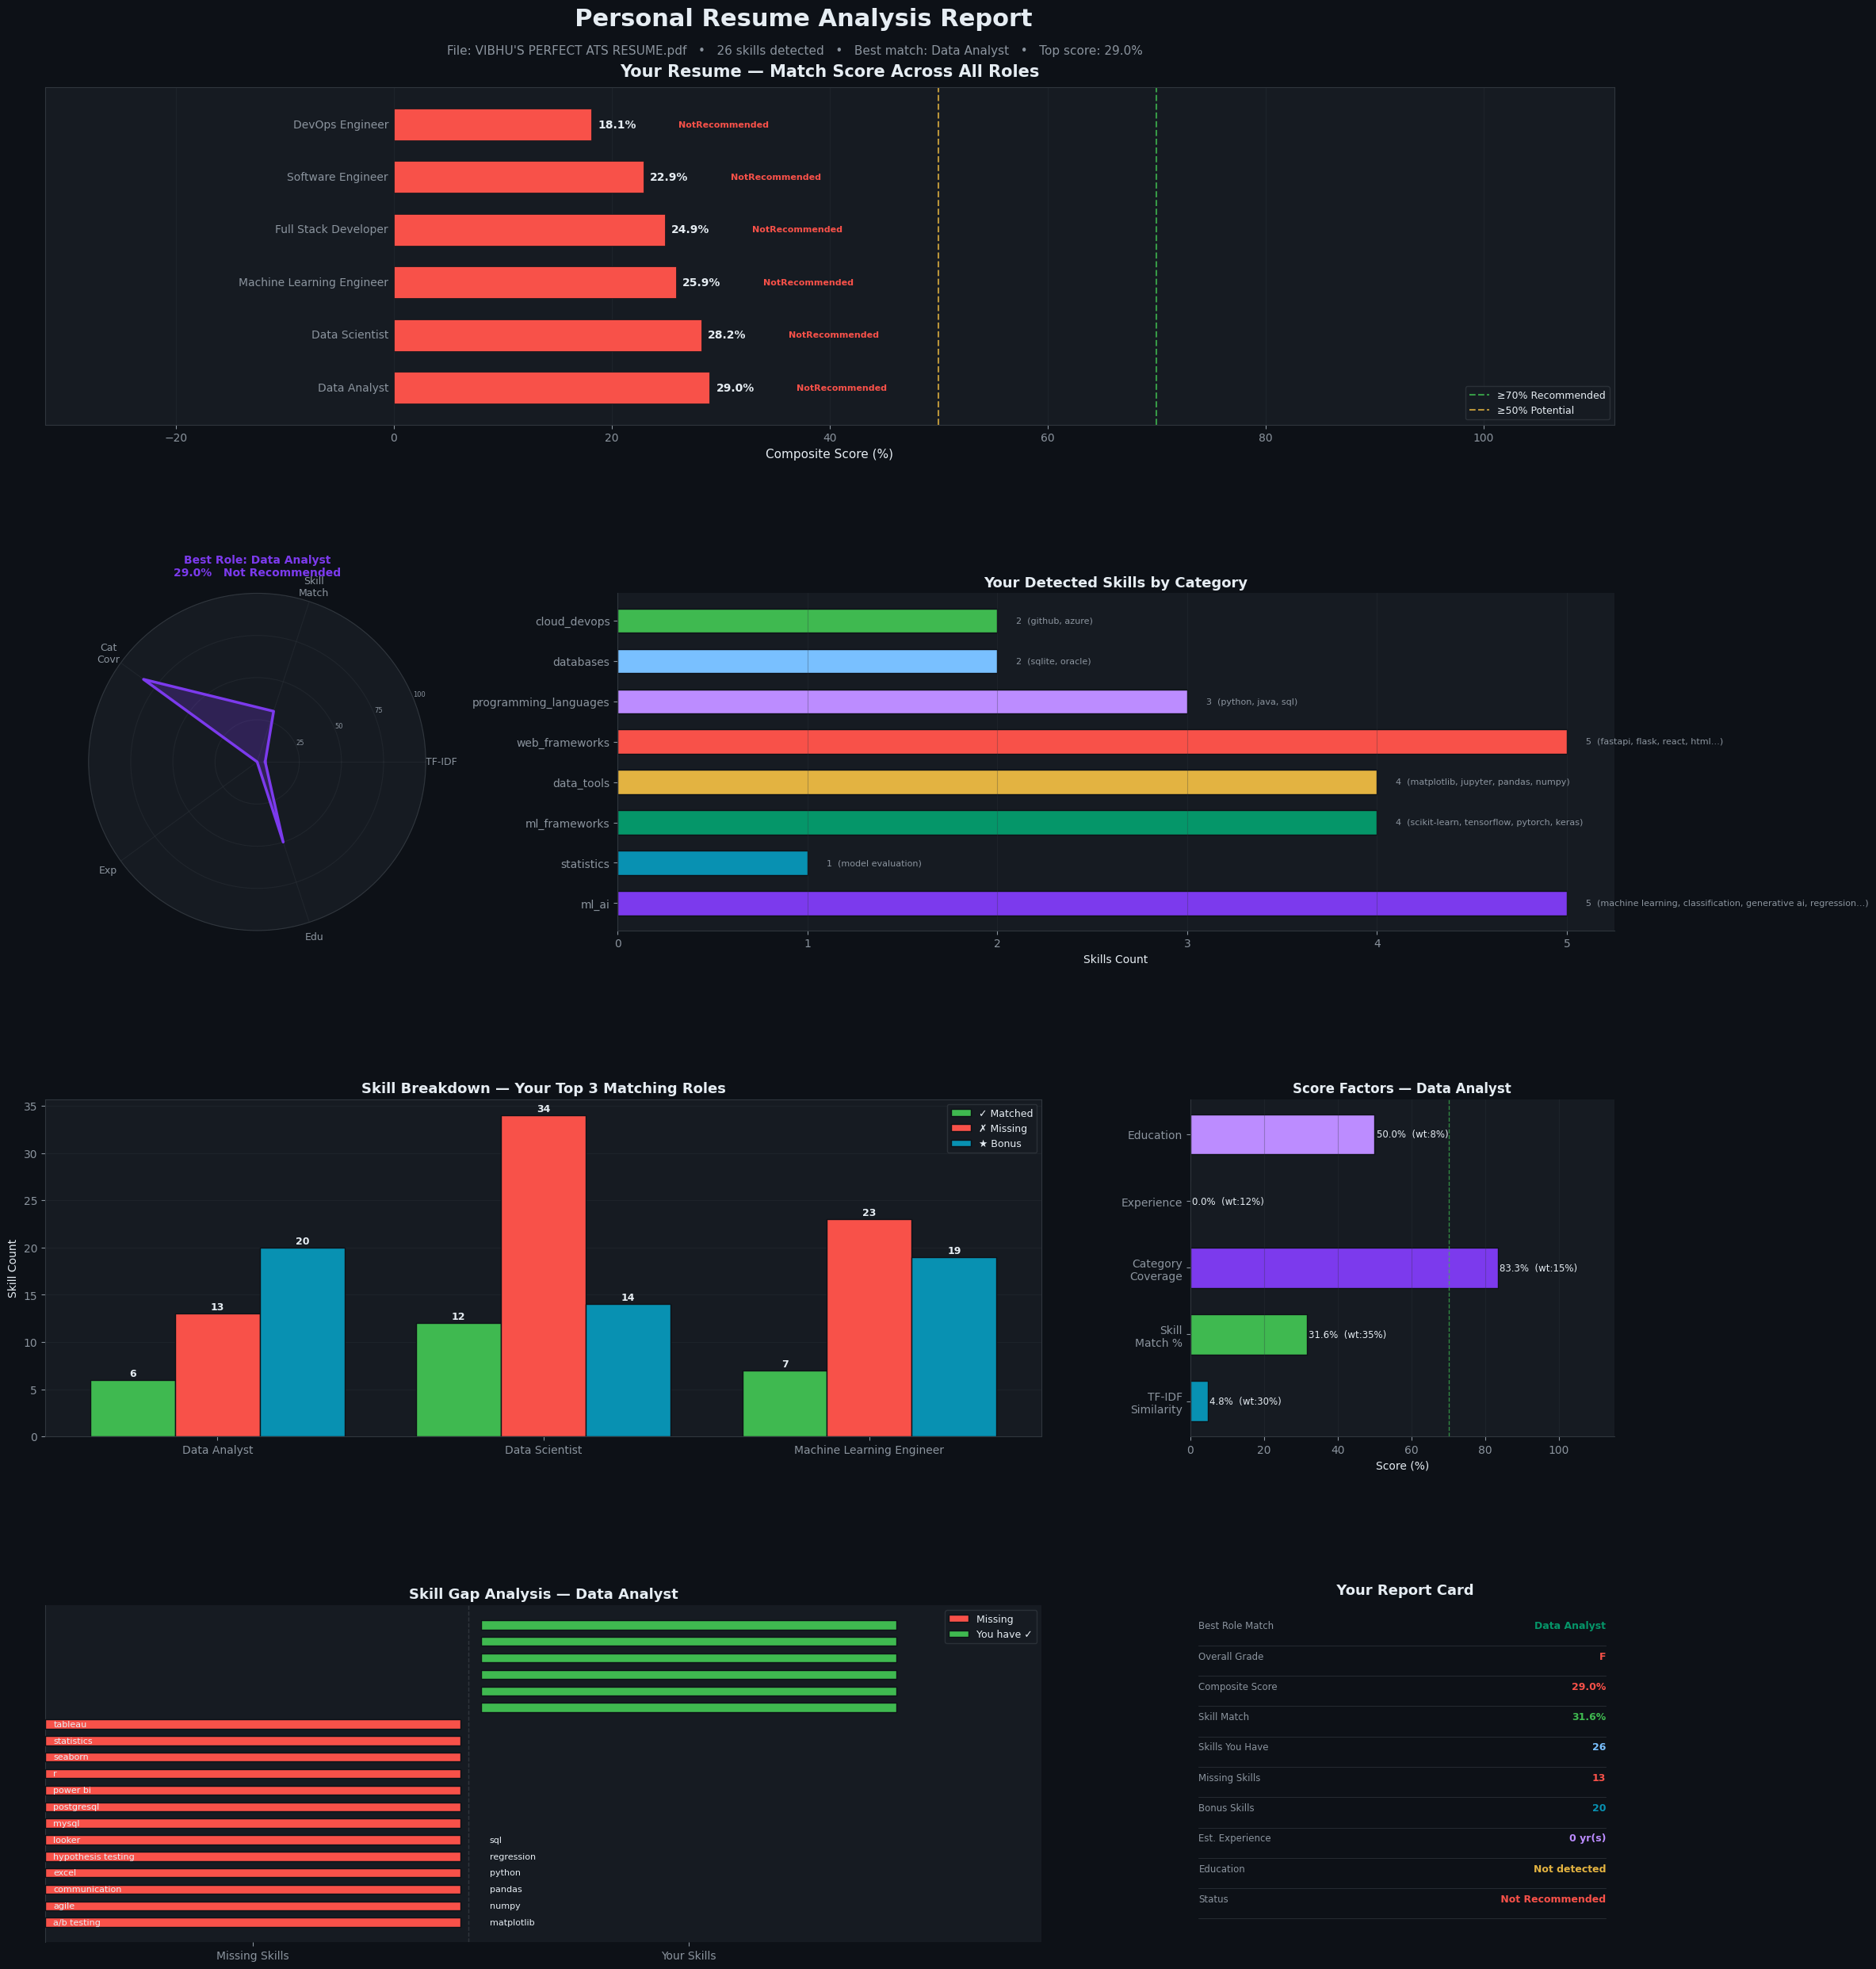

 Visual report saved → my_resume_report.png

  RESUME ANALYSIS REPORT — DETAILED TEXT VERSION
  File        : VIBHU'S PERFECT ATS RESUME.pdf
  Experience  : ~0 year(s)
  Education   : Not detected
  Skills Found: 26 skills

  BEST MATCH  : Data Analyst
  Grade       : F
  Score       : 29.0%   Not Recommended

  FACTOR BREAKDOWN:
    TF-IDF Similarity  (30%) : 4.8%
    Skill Match        (35%) : 31.6%
    Category Coverage  (15%) : 83.3%
    Experience Score   (12%) : 0.0%
    Education Score     (8%) : 50.0%

  MATCHED SKILLS (6):
    matplotlib, numpy, pandas, python, regression, sql

  MISSING SKILLS (13) — Learn these to boost your score:
    a/b testing, agile, communication, excel, hypothesis testing, looker, mysql, postgresql, power bi, r, seaborn, statistics, tableau

  BONUS SKILLS (20) — Extra skills beyond JD requirements:
    azure, classification, css, fastapi, flask, generative ai, github, html, java, jupyter, keras, llm, machine learning, model evaluation, oracle, pytorc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 Both files downloaded to your machine


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math
import numpy as np

if 'MY_ROLE_SCORES' not in dir() or not MY_ROLE_SCORES:
    print(" Run Cell 16 first to analyze your resume.")
else:
    P = {"bg":"#0d1117","panel":"#161b22","border":"#30363d",
         "green":"#3fb950","yellow":"#e3b341","red":"#f85149",
         "accent1":"#7c3aed","accent2":"#0891b2","accent3":"#059669",
         "purple":"#bc8cff","blue":"#79c0ff","text":"#e6edf3","sub":"#8b949e"}
    SC = {" Highly Recommended":"#3fb950","  Potential Fit":"#e3b341"," Not Recommended":"#f85149"}

    plt.rcParams.update({
        "font.family":"DejaVu Sans","text.color":P["text"],
        "axes.facecolor":P["panel"],"figure.facecolor":P["bg"],
        "axes.edgecolor":P["border"],"axes.labelcolor":P["text"],
        "xtick.color":P["sub"],"ytick.color":P["sub"],
        "grid.color":P["border"],"grid.alpha":0.4
    })

    fig = plt.figure(figsize=(22, 26))
    fig.patch.set_facecolor(P["bg"])
    gs  = GridSpec(4, 3, figure=fig, hspace=0.50, wspace=0.35,
                   top=0.94, bottom=0.04, left=0.07, right=0.97)

    fname_short = RESUME_FILENAME[:40] if RESUME_FILENAME else "Your Resume"
    fig.text(0.5, 0.970, "  Personal Resume Analysis Report",
             ha="center", fontsize=22, fontweight="bold", color=P["text"])
    fig.text(0.5, 0.956,
             f"File: {fname_short}   •   {len(MY_SKILLS)} skills detected   •   "
             f"Best match: {MY_BEST['role']}   •   Top score: {MY_BEST['composite_score']:.1f}%",
             ha="center", fontsize=11, color=P["sub"])

    # Panel 1: All roles ranked
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_facecolor(P["panel"])
    roles_   = [r["role"] for r in MY_ROLE_SCORES]
    scores_  = [r["composite_score"] for r in MY_ROLE_SCORES]
    statuses = [r["status"] for r in MY_ROLE_SCORES]
    bcolors  = [SC.get(s, P["sub"]) for s in statuses]

    bars = ax1.barh(range(len(roles_)), scores_, color=bcolors,
                    height=0.60, edgecolor=P["bg"], linewidth=0.5, zorder=3)
    for i, (bar, score, role, status) in enumerate(zip(bars, scores_, roles_, statuses)):
        ax1.text(bar.get_width()+0.6, i, f"{score:.1f}%",
                 va="center", fontsize=10, fontweight="bold", color=P["text"])
        ax1.text(-0.5, i, role, va="center", ha="right", fontsize=10, color=P["sub"])
        ax1.text(bar.get_width()+8, i, status.replace(" ","").replace("  ","").replace(" ",""),
                 va="center", fontsize=8, color=SC.get(status, P["sub"]), fontweight="bold")

    ax1.axvline(70, color=P["green"],  ls="--", lw=1.5, alpha=0.8, label="≥70% Recommended")
    ax1.axvline(50, color=P["yellow"], ls="--", lw=1.5, alpha=0.8, label="≥50% Potential")
    ax1.set_xlim(-32, 112); ax1.set_ylim(-0.7, len(roles_)-0.3)
    ax1.set_yticks([]); ax1.set_xlabel("Composite Score (%)", fontsize=11)
    ax1.set_title("Your Resume — Match Score Across All Roles", fontsize=15,
                  fontweight="bold", color=P["text"], pad=10)
    ax1.legend(loc="lower right", fontsize=9, facecolor=P["panel"], edgecolor=P["border"])
    ax1.grid(axis="x", alpha=0.3, zorder=0)

    # Panel 2: Radar chart — best role
    ax2 = fig.add_subplot(gs[1, 0], polar=True)
    ax2.set_facecolor(P["panel"]); ax2.spines["polar"].set_color(P["border"])
    factor_keys   = ["tfidf_score","skill_match_pct","category_pct","exp_score","edu_score"]
    factor_labels = ["TF-IDF","Skill\nMatch","Cat\nCovr","Exp","Edu"]
    N      = len(factor_keys)
    angles = [n/N*2*math.pi for n in range(N)] + [0]
    vals   = [MY_BEST[k] for k in factor_keys] + [MY_BEST[factor_keys[0]]]
    ax2.plot(angles, vals, color=P["accent1"], lw=2.5, zorder=3)
    ax2.fill(angles, vals, color=P["accent1"], alpha=0.25, zorder=2)
    ax2.set_xticks(angles[:-1]); ax2.set_xticklabels(factor_labels, size=9, color=P["sub"])
    ax2.set_ylim(0,100); ax2.set_yticks([25,50,75,100])
    ax2.set_yticklabels(["25","50","75","100"], size=6, color=P["sub"])
    ax2.grid(color=P["border"], alpha=0.4)
    ax2.set_title(f"Best Role: {MY_BEST['role']}\n{MY_BEST['composite_score']:.1f}%  {MY_BEST['status']}",
                  size=10, fontweight="bold", color=P["accent1"], pad=16)

    # Panel 3: Skills by category
    ax3 = fig.add_subplot(gs[1, 1:])
    ax3.set_facecolor(P["panel"])
    by_cat = {}
    for sk, cat in MY_SKILLS.items():
        by_cat.setdefault(cat, []).append(sk)
    cat_names  = list(by_cat.keys())
    cat_counts = [len(by_cat[c]) for c in cat_names]
    cat_colors = [P["accent1"],P["accent2"],P["accent3"],P["yellow"],
                  P["red"],P["purple"],P["blue"],P["green"],P["sub"]]
    bars3 = ax3.barh(cat_names, cat_counts, color=cat_colors[:len(cat_names)],
                     height=0.6, edgecolor=P["bg"])
    for bar, cnt, cat in zip(bars3, cat_counts, cat_names):
        skills_preview = ", ".join(by_cat[cat][:4]) + ("…" if len(by_cat[cat])>4 else "")
        ax3.text(bar.get_width()+0.1, bar.get_y()+bar.get_height()/2,
                 f"{cnt}  ({skills_preview})", va="center", fontsize=8, color=P["sub"])
    ax3.set_xlabel("Skills Count", fontsize=10)
    ax3.set_title("Your Detected Skills by Category", fontsize=13,
                  fontweight="bold", color=P["text"])
    ax3.grid(axis="x", alpha=0.3)
    ax3.spines[["top","right"]].set_visible(False)

    # Panel 4: Matched vs Missing skills for TOP 3 roles
    ax4 = fig.add_subplot(gs[2, :2])
    ax4.set_facecolor(P["panel"])
    top3_roles = MY_ROLE_SCORES[:min(3, len(MY_ROLE_SCORES))]
    top3_labels = [r["role"] for r in top3_roles]
    matched_c  = [len(r["matched_skills"]) for r in top3_roles]
    missing_c  = [len(r["missing_skills"]) for r in top3_roles]
    bonus_c    = [len(r["bonus_skills"])   for r in top3_roles]
    x = np.arange(len(top3_labels)); w = 0.26
    b1 = ax4.bar(x-w, matched_c, w, label="✓ Matched", color=P["green"],   edgecolor=P["bg"], zorder=3)
    b2 = ax4.bar(x,   missing_c, w, label="✗ Missing", color=P["red"],     edgecolor=P["bg"], zorder=3)
    b3 = ax4.bar(x+w, bonus_c,   w, label="★ Bonus",   color=P["accent2"], edgecolor=P["bg"], zorder=3)
    for grp in [b1,b2,b3]:
        for bar in grp:
            h = bar.get_height()
            if h > 0:
                ax4.text(bar.get_x()+bar.get_width()/2, h+0.15, str(int(h)),
                         ha="center", va="bottom", fontsize=9, color=P["text"], fontweight="bold")
    ax4.set_xticks(x); ax4.set_xticklabels(top3_labels, fontsize=10)
    ax4.set_ylabel("Skill Count", fontsize=10)
    ax4.set_title("Skill Breakdown — Your Top 3 Matching Roles", fontsize=13,
                  fontweight="bold", color=P["text"])
    ax4.legend(fontsize=9, facecolor=P["panel"], edgecolor=P["border"])
    ax4.grid(axis="y", alpha=0.3, zorder=0)

    # Panel 5: Score factor breakdown
    ax5 = fig.add_subplot(gs[2, 2])
    ax5.set_facecolor(P["panel"])
    factor_names  = ["TF-IDF\nSimilarity","Skill\nMatch %","Category\nCoverage","Experience","Education"]
    factor_values = [MY_BEST[k] for k in factor_keys]
    factor_weights= [30, 35, 15, 12, 8]
    fcols = [P["accent2"],P["green"],P["accent1"],P["yellow"],P["purple"]]
    bars5 = ax5.barh(factor_names, factor_values, color=fcols, height=0.6, edgecolor=P["bg"])
    for bar, val, wt in zip(bars5, factor_values, factor_weights):
        ax5.text(bar.get_width()+0.5, bar.get_y()+bar.get_height()/2,
                 f"{val:.1f}%  (wt:{wt}%)", va="center", fontsize=8.5, color=P["text"])
    ax5.set_xlim(0, 115); ax5.set_xlabel("Score (%)", fontsize=10)
    ax5.axvline(70, color=P["green"], ls="--", lw=1, alpha=0.7)
    ax5.set_title(f"Score Factors — {MY_BEST['role']}", fontsize=12,
                  fontweight="bold", color=P["text"])
    ax5.grid(axis="x", alpha=0.3); ax5.spines[["top","right"]].set_visible(False)

    # Panel 6: Skill Gap for best role
    ax6 = fig.add_subplot(gs[3, :2])
    ax6.set_facecolor(P["panel"])
    miss = MY_BEST["missing_skills"][:20]
    hit  = MY_BEST["matched_skills"][:20]
    if miss:
        ax6.barh(miss, [1]*len(miss), color=P["red"],   height=0.55,
                 edgecolor=P["bg"], label="Missing ", zorder=3)
    if hit:
        ax6.barh(hit,  [1]*len(hit),  color=P["green"], height=0.55,
                 edgecolor=P["bg"], label="You have ✓", zorder=3, left=[1.05]*len(hit))
    ax6.set_xlim(0, 2.4)
    ax6.set_xticks([0.5, 1.55]); ax6.set_xticklabels(["Missing Skills", "Your Skills"],
                                                        fontsize=10, color=P["sub"])
    ax6.set_title(f"Skill Gap Analysis — {MY_BEST['role']}", fontsize=13,
                  fontweight="bold", color=P["text"])
    ax6.axvline(1.02, color=P["border"], lw=1, ls="--")
    ax6.legend(fontsize=9, facecolor=P["panel"], edgecolor=P["border"], loc="upper right")
    ax6.grid(False); ax6.spines[["top","right","bottom"]].set_visible(False)
    ax6.set_yticks([]); ax6.tick_params(left=False)
    # Add skill labels manually
    for i, sk in enumerate(miss):
        ax6.text(0.02, i, sk, va="center", fontsize=8, color=P["text"])
    for i, sk in enumerate(hit):
        ax6.text(1.07, i, sk, va="center", fontsize=8, color=P["text"])

    # Panel 7: Summary card
    ax7 = fig.add_subplot(gs[3, 2])
    ax7.set_facecolor(P["panel"]); ax7.axis("off")
    ax7.set_title(" Your Report Card", fontsize=13, fontweight="bold", color=P["text"], pad=10)

    grade_score = MY_BEST["composite_score"]
    grade = ("A+" if grade_score>=90 else "A"  if grade_score>=80 else
             "B+" if grade_score>=75 else "B"  if grade_score>=70 else
             "C+" if grade_score>=65 else "C"  if grade_score>=55 else
             "D"  if grade_score>=50 else "F")
    grade_color = (P["green"] if grade_score>=70 else
                   P["yellow"] if grade_score>=50 else P["red"])

    stats = [
        ("Best Role Match",     MY_BEST["role"][:20],                        P["accent3"]),
        ("Overall Grade",       grade,                                         grade_color),
        ("Composite Score",     f"{MY_BEST['composite_score']:.1f}%",          grade_color),
        ("Skill Match",         f"{MY_BEST['skill_match_pct']:.1f}%",          P["green"]),
        ("Skills You Have",     str(len(MY_SKILLS)),                           P["blue"]),
        ("Missing Skills",      str(len(MY_BEST["missing_skills"])),           P["red"]),
        ("Bonus Skills",        str(len(MY_BEST["bonus_skills"])),             P["accent2"]),
        ("Est. Experience",     f"{my_years} yr(s)",                           P["purple"]),
        ("Education",           my_edu_label,                                  P["yellow"]),
        ("Status",              MY_BEST["status"],                             grade_color),
    ]
    y = 0.93
    for lbl, val, col in stats:
        ax7.text(0.02, y, lbl, transform=ax7.transAxes, fontsize=8.5, color=P["sub"])
        ax7.text(0.98, y, val, transform=ax7.transAxes, fontsize=9,
                 fontweight="bold", color=col, ha="right")
        y -= 0.090
        ax7.plot([0.02,0.98],[y+0.040,y+0.040], color=P["border"],
                 linewidth=0.5, transform=ax7.transAxes, clip_on=False)

    plt.savefig("my_resume_report.png", dpi=150, bbox_inches="tight", facecolor=P["bg"])
    plt.show()
    print(" Visual report saved → my_resume_report.png")

    # Text Report
    report_lines = [
        "="*70,
        "  RESUME ANALYSIS REPORT — DETAILED TEXT VERSION",
        "="*70,
        f"  File        : {RESUME_FILENAME}",
        f"  Experience  : ~{my_years} year(s)",
        f"  Education   : {my_edu_label}",
        f"  Skills Found: {len(MY_SKILLS)} skills",
        "",
        f"  BEST MATCH  : {MY_BEST['role']}",
        f"  Grade       : {grade}",
        f"  Score       : {MY_BEST['composite_score']:.1f}%  {MY_BEST['status']}",
        "",
        "  FACTOR BREAKDOWN:",
        f"    TF-IDF Similarity  (30%) : {MY_BEST['tfidf_score']:.1f}%",
        f"    Skill Match        (35%) : {MY_BEST['skill_match_pct']:.1f}%",
        f"    Category Coverage  (15%) : {MY_BEST['category_pct']:.1f}%",
        f"    Experience Score   (12%) : {MY_BEST['exp_score']:.1f}%",
        f"    Education Score     (8%) : {MY_BEST['edu_score']:.1f}%",
        "",
        f"  MATCHED SKILLS ({len(MY_BEST['matched_skills'])}):",
        "    " + ", ".join(MY_BEST["matched_skills"]),
        "",
        f"  MISSING SKILLS ({len(MY_BEST['missing_skills'])}) — Learn these to boost your score:",
        "    " + (", ".join(MY_BEST["missing_skills"]) or "None — you're fully qualified!"),
        "",
        f"  BONUS SKILLS ({len(MY_BEST['bonus_skills'])}) — Extra skills beyond JD requirements:",
        "    " + (", ".join(list(MY_BEST["bonus_skills"])[:20]) or "None"),
        "",
        "  ALL ROLES RANKED:",
    ]
    for i, rs in enumerate(MY_ROLE_SCORES):
        report_lines.append(f"    #{i+1} {rs['role']:<28} {rs['composite_score']:5.1f}%  {rs['status']}")
    report_lines += ["", "  SKILL IMPROVEMENT RECOMMENDATIONS:"]
    for i, sk in enumerate(MY_BEST["missing_skills"][:10], 1):
        report_lines.append(f"    {i:>2}. Learn / highlight: {sk}")
    report_lines.append("="*70)

    report_text = "\n".join(report_lines)
    print("\n" + report_text)

    # Save report
    report_fname = (RESUME_FILENAME.rsplit(".",1)[0] if RESUME_FILENAME else "resume") + "_analysis_report.txt"
    with open(report_fname, "w") as f:
        f.write(report_text)
    print(f"\n Text report saved → {report_fname}")

    # Download both files in Colab
    try:
        from google.colab import files as colab_files
        colab_files.download("my_resume_report.png")
        colab_files.download(report_fname)
        print(" Both files downloaded to your machine")
    except ImportError:
        print("   (Not in Colab — files saved in current directory)")
